In [ ]:
import csv
import os

main_folder_path = '/dhc/home/youngbin.ko/brain_data/data/train_gp_new_120'

input_csv_path = '/dhc/home/youngbin.ko/brain_data/survival_info.csv'
output_csv_path = '/dhc/home/youngbin.ko/brain_data/data/survival_gp.csv'

with open(output_csv_path, 'w', newline='') as csv_output:
    writer = csv.writer(csv_output)
    
    for subfolder_name in sorted(os.listdir(main_folder_path)):
        subfolder_path = os.path.join(main_folder_path, subfolder_name)
        
        if os.path.isdir(subfolder_path):
            with open(input_csv_path, 'r') as csv_input:
                reader = csv.reader(csv_input)
                
                filtered_rows = filter(lambda row: row[0] == subfolder_name, reader)
                sorted_rows = sorted(filtered_rows, key=lambda row: row[0])
                
                writer.writerows(sorted_rows)


In [ ]:
path = np.load("/dhc/home/youngbin.ko/random.npy",allow_pickle=True)

In [ ]:
import shutil

source_folder_path_1 = "/dhc/home/youngbin.ko/brain_data/data/train_for_nf_344"
source_folder_path_2 = "/dhc/home/youngbin.ko/brain_data/train_for_guassian_120"
target_path = "/dhc/home/youngbin.ko/brain_data/data/train_nf"

for folder_name in os.listdir(source_folder_path_1):
    src_path = os.path.join(source_folder_path_1, folder_name)
    dst_path = os.path.join(target_path, folder_name)
    shutil.copytree(src_path, dst_path)

for folder_name in os.listdir(source_folder_path_2):
    src_path = os.path.join(source_folder_path_2, folder_name)
    dst_path = os.path.join(target_path, folder_name)
    shutil.copytree(src_path, dst_path)

In [ ]:
parent_folder_path = "/dhc/home/youngbin.ko/brain_data/data/train_nf"
target_path = "/dhc/home/youngbin.ko/brain_data/data/train_gp_new_120"

folders_to_move = path

for folder_name in os.listdir(parent_folder_path):
    if folder_name in folders_to_move:
        src_path = os.path.join(parent_folder_path, folder_name)
        dst_path = os.path.join(target_path, folder_name)
        shutil.move(src_path, dst_path)


In [ ]:
input_dir = "/dhc/home/youngbin.ko/glow_brain/data_gp/slices_64_new" # Shape (155, 64, 64, 4) npy
input_files = sorted(os.listdir(input_dir))
input_data = np.concatenate([np.expand_dims((np.load(os.path.join(input_dir, f))),0) for f in input_files], axis=0)

In [ ]:
print(input_data.shape)

In [ ]:
reshaped_input = np.reshape(input_data, (120, 155*64*64*4))
print(reshaped_input.shape)

In [ ]:
import numpy as np
import torch
import gpytorch
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

input_dir = "/dhc/home/youngbin.ko/glow_brain/model/output" # Shape (1, 2539520) npy
input_files = sorted(os.listdir(input_dir))
input_data = np.concatenate([np.load(os.path.join(input_dir, f)) for f in input_files], axis=0)
print(input_data.shape) #
train_x = torch.from_numpy(input_data).float().to(device)

output_data = np.load("/dhc/home/youngbin.ko/brain_data/data/survival_days.npy")  # Shape (120,)
train_y = torch.from_numpy(output_data.flatten()).float().view(-1, 1).to(device)
#train_y = torch.from_numpy(output_data).float().view(-1, 1)  # Reshape to (120, 1)
print(train_y.shape)

k=4
input_folds = np.array_split(input_data, k)
output_folds = np.array_split(output_data, k)

class GaussianProcessModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()  # Use a constant mean function
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()  # Use an RBF kernel
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

likelihood = gpytorch.likelihoods.GaussianLikelihood()
#gpytorch.likelihoods.BetaLikelihood
model = GaussianProcessModel(train_x, train_y, likelihood)

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

num_epochs = 100
for epoch in range(num_epochs):
    model.train()

    optimizer.zero_grad()

    output = model(train_x)
    loss = -likelihood(output).log_prob(train_y).mean()

    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss {loss.item()}")


In [ ]:
import numpy as np
import torch
import gpytorch
from sklearn.model_selection import KFold
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

input_dir = "/dhc/home/youngbin.ko/glow_brain/model/output" # Shape (1,2539520 ) npy
input_files = sorted(os.listdir(input_dir))
input_data = np.concatenate([np.load(os.path.join(input_dir, f)) for f in input_files], axis=0)
print(input_data.shape) #(120,2539520)
train_x = torch.from_numpy(input_data).float().to(device)

output_data = np.load("/dhc/home/youngbin.ko/brain_data/data/survival_days.npy")  # Shape (120,)
train_y = torch.from_numpy(output_data.flatten()).float().view(-1, 1).to(device)  # Reshape to (120, 1)
print(train_y.shape) #(120, 1)

In [ ]:
class GaussianProcessModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()  # Use a constant mean function
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()  # Use an RBF kernel
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [ ]:
kf = KFold(n_splits=4, shuffle=True, random_state=42)
num_epochs = 100

for fold, (train_index, valid_index) in enumerate(kf.split(train_x)):
    # Get train and validation data
    train_x_fold = train_x[train_index]
    train_y_fold = train_y[train_index]
    valid_x_fold = train_x[valid_index]
    valid_y_fold = train_y[valid_index]

    # Initialize model and likelihood
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = GaussianProcessModel(train_x_fold, train_y_fold, likelihood)

    # Define optimizer
    optimizer = torch.optim.LBFGS(model.parameters(), line_search_fn='strong_wolfe')

    # Train the model
    def closure():
        optimizer.zero_grad()
        output = model(train_x_fold)
        loss = -likelihood(output).log_prob(train_y_fold).mean()
        loss.backward()
        return loss

    for epoch in range(num_epochs):
        model.train()
        optimizer.step(closure)
        if epoch % 10 == 0:
            print(f"Fold {fold}, Epoch {epoch}, Loss {closure().item()}")

    # Evaluate the model on the validation set
    model.eval()
    with torch.no_grad():
        output = model(valid_x_fold)
        loss = -likelihood(output).log_prob(valid_y_fold).mean()
        print(f"Fold {fold}, Validation Loss: {loss.item()}")

        f_preds = model(valid_x_fold)
        y_preds = likelihood(model(valid_x_fold))
        f_mean = f_preds.mean
        f_var = f_preds.variance
        f_covar = f_preds.covariance_matrix
        f_samples = f_preds.sample(sample_shape=torch.Size(1000,))

In [ ]:
import numpy as np
import torch
import gpytorch
from sklearn.model_selection import KFold
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

input_dir = "/dhc/home/youngbin.ko/glow_brain/model/output" # Shape (1,2539520 ) npy
input_files = sorted(os.listdir(input_dir))
input_data = np.concatenate([np.load(os.path.join(input_dir, f)) for f in input_files], axis=0)
print(input_data.shape) #(120,2539520)
train_x = torch.from_numpy(input_data).float().to(device)

output_data = np.load("/dhc/home/youngbin.ko/brain_data/data/survival_days.npy")  # Shape (120,)
train_y = torch.from_numpy(output_data).float().view(-1, 1).to(device)  # Reshape to (120, 1)
print(train_y.shape) #(120, 1)

kf = KFold(n_splits=4, shuffle=True, random_state=42)
num_epochs = 100

for fold, (train_index, valid_index) in enumerate(kf.split(train_x)):
    # Get train and validation data
    train_x_fold = train_x[train_index]
    train_y_fold = train_y[train_index]
    valid_x_fold = train_x[valid_index]
    valid_y_fold = train_y[valid_index]

    # Initialize model and likelihood
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = GaussianProcessModel(train_x_fold, train_y_fold, likelihood)

    # Define optimizer
    optimizer = torch.optim.LBFGS(model.parameters(), line_search_fn='strong_wolfe')

    # Train the model
    def closure():
        optimizer.zero_grad()
        output = model(train_x_fold)
        loss = -likelihood(output).log_prob(train_y_fold).mean()
        loss.backward()
        return loss

    for epoch in range(num_epochs):
        model.train()
        optimizer.step(closure)
        if epoch % 10 == 0:
            print(f"Fold {fold}, Epoch {epoch}, Loss {closure().item()}")

    # Evaluate the model on the validation set
    model.eval()
    with torch.no_grad():
        output = model(valid_x_fold)
        loss = -likelihood(output).log_prob(valid_y_fold).mean()
        print(f"Fold {fold}, Validation Loss: {loss.item()}")

        f_preds = model(valid_x_fold)
        y_preds = likelihood(model(valid_x_fold))
        f_mean = f_preds.mean
        f_var = f_preds.variance
        f_covar = f_preds.covariance_matrix
        f_samples = f_preds.sample(sample_shape=torch.Size(1000,))

In [ ]:
class GaussianProcessModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()  # Use a constant mean function
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()  # Use an RBF kernel
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        #mean_x = mean_x.view(-1, 1)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [ ]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [8]:
import numpy as np
import torch
import gpytorch
from sklearn.model_selection import KFold
import os

# check if GPU is available and set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
#device = torch.device('cpu')
input_dir = "/dhc/home/youngbin.ko/glow_brain/model/output" # Shape (1,2539520 ) npy
input_files = sorted(os.listdir(input_dir))
input_data = np.concatenate([np.load(os.path.join(input_dir, f)) for f in input_files], axis=0)
print(input_data.shape) #(120,2539520)
train_x = torch.from_numpy(input_data).float().to(device)
#train_x = torch.from_numpy(input_data).float()

output_data = np.load("/dhc/home/youngbin.ko/brain_data/data/survival_days.npy")  # Shape (120,)
train_y = torch.from_numpy(output_data.flatten()).float().to(device)
#train_y = torch.from_numpy(output_data.flatten()).float().view(1, -1).to(device)  # Reshape to (120, 1)
#train_y = torch.from_numpy(output_data.flatten()).float().view(-1, 1) 
print(train_y.shape) #(120, 1)

kf = KFold(n_splits=4, shuffle=True, random_state=42)
num_epochs = 100

class GaussianProcessModel(gpytorch.models.ExactGP): #change to linear regression (output from NF) 
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()  # Use a constant mean function
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()  # Use an RBF kernel
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

for fold, (train_index, valid_index) in enumerate(kf.split(train_x)):
    # Get train and validation data
    train_x_fold = train_x[train_index]
    train_y_fold = train_y[train_index]
    valid_x_fold = train_x[valid_index]
    valid_y_fold = train_y[valid_index]

    # Initialize model and likelihood
    likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
    model = GaussianProcessModel(train_x_fold, train_y_fold, likelihood).to(device)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    # Define optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

    print(f"Fold {fold}, Prior mean: {model.mean_module.constant.item()}")
    print(f"Fold {fold}, Training labels shape: {train_y_fold.shape}")
    # Train the model
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        output = model(train_x_fold)
        #loss = -likelihood(output).log_prob(train_y_fold).mean()
        #loss = ((train_y_fold-output)**2)
        loss = -mll(output, train_y_fold)
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f"Fold {fold}, Epoch {epoch}, Loss {loss.item()}")

    # Evaluate the model on the validation set
    model.eval()
    with torch.no_grad():
        output = model(valid_x_fold)
        loss = -likelihood(output).log_prob(valid_y_fold).mean()
        print(f"Fold {fold}, Validation Loss: {loss.item()}")

        f_preds = model(valid_x_fold)
        y_preds = likelihood(model(valid_x_fold))
        f_mean = f_preds.mean
        f_var = f_preds.variance
        f_covar = f_preds.covariance_matrix
        #f_samples = f_preds.sample(sample_shape=torch.Size(1000,))


Using device: cuda
(120, 2539520)
torch.Size([120])
Fold 0, Prior mean: 0.0
Fold 0, Training labels shape: torch.Size([90])
Fold 0, Epoch 0, Loss 144536.71875
Fold 0, Epoch 10, Loss 77837.0859375
Fold 0, Epoch 20, Loss 52163.8359375
Fold 0, Epoch 30, Loss 40709.44140625
Fold 0, Epoch 40, Loss 34614.015625
Fold 0, Epoch 50, Loss 30844.60546875
Fold 0, Epoch 60, Loss 28225.6640625
Fold 0, Epoch 70, Loss 26246.900390625
Fold 0, Epoch 80, Loss 24664.056640625
Fold 0, Epoch 90, Loss 23348.8203125
Fold 0, Validation Loss: 556400.1875
Fold 1, Prior mean: 0.0
Fold 1, Training labels shape: torch.Size([90])
Fold 1, Epoch 0, Loss 121153.8671875
Fold 1, Epoch 10, Loss 65233.2578125
Fold 1, Epoch 20, Loss 43710.99609375
Fold 1, Epoch 30, Loss 34108.875
Fold 1, Epoch 40, Loss 28999.029296875
Fold 1, Epoch 50, Loss 25838.91796875
Fold 1, Epoch 60, Loss 23643.162109375
Fold 1, Epoch 70, Loss 21984.01953125
Fold 1, Epoch 80, Loss 20656.763671875
Fold 1, Epoch 90, Loss 19553.8359375
Fold 1, Validation 

In [14]:
y_preds.mean.cpu()

tensor([6.3258, 6.3258, 6.3258, 6.3258, 6.3258, 6.3258, 6.3258, 6.3258, 6.3258,
        6.3258, 6.3258, 6.3258, 6.3258, 6.3258, 6.3258, 6.3258, 6.3258, 6.3258,
        6.3258, 6.3258, 6.3258, 6.3258, 6.3258, 6.3258, 6.3258, 6.3258, 6.3258,
        6.3258, 6.3258, 6.3258])

In [ ]:
ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')

In [11]:
type(y_preds)

gpytorch.distributions.multivariate_normal.MultivariateNormal

In [12]:
print(f_mean)

tensor([6.3258, 6.3258, 6.3258, 6.3258, 6.3258, 6.3258, 6.3258, 6.3258, 6.3258,
        6.3258, 6.3258, 6.3258, 6.3258, 6.3258, 6.3258, 6.3258, 6.3258, 6.3258,
        6.3258, 6.3258, 6.3258, 6.3258, 6.3258, 6.3258, 6.3258, 6.3258, 6.3258,
        6.3258, 6.3258, 6.3258], device='cuda:0')


In [10]:
print(f)

tensor([ 788.,  465.,  336., 1283.,   33.,  229., 1592.,  614.,   58.,  416.,
         240.,  300.,  630.,  630.,  355.,  737.,   67.,  828.,  747.,  103.,
         382.,  372.,  232.,  434.,  244.,   82.,  147.,  260.,  184.,   62.],
       device='cuda:0')


In [8]:
#linear regression with output from NF
import numpy as np
import torch
import gpytorch
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

input_dir = "/dhc/home/youngbin.ko/glow_brain/model/output" # Shape (1,2539520 ) npy
input_files = sorted(os.listdir(input_dir))
input_data = np.concatenate([np.load(os.path.join(input_dir, f)) for f in input_files], axis=0)
print(input_data.shape) #(120,2539520)

output_data = np.load("/dhc/home/youngbin.ko/brain_data/data/survival_days.npy")  # Shape (120,)
input_data = torch.from_numpy(input_data).float().to(device)
output_data = torch.from_numpy(output_data.flatten()).float().to(device)

train_size = int(0.8 * len(input_data))
train_x, valid_x = input_data[:train_size], input_data[train_size:]
train_y, valid_y = output_data[:train_size], output_data[train_size:]

num_epochs = 100

class LinearRegressionModel(torch.nn.Module):
    def __init__(self):
        super(LinearRegressionModel, self).__init__()
        self.linear = torch.nn.Linear(input_data.shape[1], 1)

    def forward(self, x):
        out = self.linear(x)
        return out

model = LinearRegressionModel().to(device)
criterion = torch.nn.MSELoss(reduction = 'mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

print(f"Training labels shape: {train_y.shape}")
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    output = model(train_x)
    loss = criterion(output, train_y)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss {loss.item()}")

model.eval()
with torch.no_grad():
    output = model(valid_x)
    print(output)
    # loss = criterion(output, valid_y)
    # print(f"Validation Loss: {loss.item()}")

    y_preds = output.flatten()
    loss = criterion(y_preds, valid_y)
    # print(f"Validation Loss: {loss.item()}")
    print(f"Validation Loss: {loss}")


Using device: cuda
(120, 2539520)
Training labels shape: torch.Size([96])
Epoch 0, Loss 390123.46875
Epoch 10, Loss 178450512.0
Epoch 20, Loss 40174408.0
Epoch 30, Loss 386331.84375
Epoch 40, Loss 1737234.5
Epoch 50, Loss 1351676.5
Epoch 60, Loss 498259.5
Epoch 70, Loss 175103.0625
Epoch 80, Loss 184468.890625
Epoch 90, Loss 208995.421875
tensor([[494.8763],
        [505.1411],
        [487.5457],
        [493.6921],
        [523.8223],
        [503.0511],
        [510.7884],
        [483.9029],
        [484.8311],
        [495.2319],
        [497.0187],
        [468.2321],
        [480.0355],
        [503.2893],
        [490.9646],
        [531.8245],
        [467.5026],
        [526.8805],
        [509.3709],
        [507.7156],
        [502.5511],
        [510.7158],
        [495.3963],
        [479.2571]], device='cuda:0')
Validation Loss: 116807.40625


In [9]:
print(valid_y)

tensor([ 448.,  296.,  626.,  372.,  121.,   30.,  232.,  434.,    5.,  244.,
          82.,  346.,  147., 1076.,  903., 1293.,  260.,  351.,  880.,  184.,
         197.,  456.,  540.,   62.], device='cuda:0')


In [2]:
print(y_preds)

tensor([496.7550, 500.4889, 487.6410, 496.5576, 526.0389, 501.9958, 511.0885,
        482.8078, 484.6608, 497.4300, 500.1317, 466.7158, 479.1836, 503.2531,
        486.0622, 533.7513, 468.9354, 526.1563, 511.6059, 505.7967, 505.9279,
        513.1158, 494.8851, 480.3745], device='cuda:0')


In [9]:
print(min(y_preds))

tensor(467.5026, device='cuda:0')


In [10]:
print(max(y_preds))

tensor(531.8245, device='cuda:0')


In [22]:
print(output)

tensor([[494.0627],
        [501.9978],
        [486.6934],
        [492.3466],
        [523.3304],
        [505.7557],
        [512.6681],
        [484.4684],
        [480.3996],
        [496.4120],
        [500.8266],
        [466.0086],
        [477.9927],
        [504.4886],
        [488.8863],
        [534.4900],
        [470.8798],
        [526.5191],
        [513.6910],
        [507.5645],
        [505.8149],
        [512.7242],
        [493.8711],
        [480.9348]], device='cuda:0')


In [3]:
test = torch.sum((y_preds - valid_y)**2)

In [4]:
print((test**0.5)/24)

tensor(69.8177, device='cuda:0')


In [15]:
print(((torch.sum((output - valid_y)**2))**0.5)/24)

tensor(346.6943, device='cuda:0')


In [6]:
data_iter = iter(train_loader)
batch_X, batch_y = data_iter.next()

print(batch_X.shape) # should output (155, 120, 64, 64)
print(batch_y.shape)

torch.Size([72, 155, 64, 64, 4])
torch.Size([72])


In [7]:
# cnn with original data
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_dir = "/dhc/home/youngbin.ko/glow_brain/data_gp/slices_64_new"
input_files = sorted(os.listdir(input_dir))
X = []
for f in input_files:
    data = np.load(os.path.join(input_dir, f))  # Shape (155, 64, 64, 4)
    X.append(data)
X = np.stack(X, axis=0)  # Shape (120, 155, 64, 64, 4)

output_data = np.load("/dhc/home/youngbin.ko/brain_data/data/survival_days.npy")  # Shape (120,)

train_X, test_X, train_y, test_y = train_test_split(X, output_data, test_size=0.2, random_state=10)
train_X, valid_X, train_y, valid_y = train_test_split(train_X, train_y, test_size=0.25, random_state=10)

train_loader = DataLoader(TensorDataset(torch.from_numpy(train_X).float(), torch.from_numpy(train_y).float()), batch_size=155, shuffle=True)
valid_loader = DataLoader(TensorDataset(torch.from_numpy(valid_X).float(), torch.from_numpy(valid_y).float()), batch_size=155)
test_loader = DataLoader(TensorDataset(torch.from_numpy(test_X).float(), torch.from_numpy(test_y).float()), batch_size=155)

class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        self.conv1 = nn.Conv3d(155, 16, kernel_size=3, padding=(1, 1, 0)) # Add padding
        self.pool = nn.MaxPool3d(kernel_size=2)
        self.conv2 = nn.Conv3d(16, 32, kernel_size=3)
        self.fc1 = nn.Linear(32 * 15 * 15 * 38 * 155, 128) # Update the input size
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 32 * 15 * 15 * 38 * 155)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x


model = MyCNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

best_loss = float("inf")
patience = 10  # Stop training if validation loss does not improve for 10 epochs
counter = 0
for epoch in range(100):
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs.to(device))
        loss = criterion(outputs, targets.unsqueeze(1).to(device))
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss /= len(train_loader.dataset)

    # Evaluate the model on the validation set and check for improvement
    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for inputs, targets in valid_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            valid_loss += loss.item() * inputs.size(0)

        valid_loss /= len(valid_loader.dataset)
        print(f"Validation Loss: {valid_loss}")
        
        if valid_loss < best_loss:
            best_loss = valid_loss
            counter = 0
        else:
            counter += 1
        if counter >= patience:
            print(f"No improvement in {patience} epochs, stopping early.")
            break


RuntimeError: CUDA out of memory. Tried to allocate 20.22 GiB (GPU 0; 10.76 GiB total capacity; 6.19 GiB already allocated; 3.54 GiB free; 6.23 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [1]:
# cnn with original data
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"
input_dir = "/dhc/home/youngbin.ko/glow_brain/data_gp/slices_64_new"
input_files = sorted(os.listdir(input_dir))
X = []
for f in input_files:
    data = np.load(os.path.join(input_dir, f))  # Shape (155, 64, 64, 4)
    X.append(data)
X = np.stack(X, axis=0)  # Shape (120, 155, 64, 64, 4)
X = np.transpose(X, (0, 4, 2, 3, 1))
output_data = np.load("/dhc/home/youngbin.ko/brain_data/data/survival_days.npy")  # Shape (120,)

train_X, test_X, train_y, test_y = train_test_split(X, output_data, test_size=0.2, random_state=10)
train_X, valid_X, train_y, valid_y = train_test_split(train_X, train_y, test_size=0.25, random_state=10)

train_loader = DataLoader(TensorDataset(torch.from_numpy(train_X).float(), torch.from_numpy(train_y).float()), batch_size=10, shuffle=True) # shape (72, 155, 64, 64, 4)
valid_loader = DataLoader(TensorDataset(torch.from_numpy(valid_X).float(), torch.from_numpy(valid_y).float()), batch_size=10)
test_loader = DataLoader(TensorDataset(torch.from_numpy(test_X).float(), torch.from_numpy(test_y).float()), batch_size=10)

class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        self.conv1 = nn.Conv3d(4, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv3d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 16 * 16 * 19, 10)
        self.fc2 = nn.Linear(10, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 16 * 16 * 19)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def train(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for i, (inputs, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs.to(device))
        loss = criterion(outputs, targets.to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    return epoch_loss

def evaluate(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item()
    epoch_loss = running_loss / len(val_loader)
    return epoch_loss

model = MyCNN().to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

num_epochs = 50
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer)
    val_loss = evaluate(model, valid_loader, criterion)
    print('Epoch [{}/{}], Train Loss: {:.4f}, Val Loss: {:.4f}'.format(epoch+1, num_epochs, train_loss, val_loss))

test_loss = evaluate(model, test_loader, criterion)
print('Test Loss: {:.4f}'.format(test_loss))

/dhc/home/youngbin.ko/conda3/envs/copy_env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/dhc/home/youngbin.ko/conda3/envs/copy_env/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/dhc/home/youngbin.ko/conda3/envs/copy_env/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, targe

Epoch [1/50], Train Loss: 191366.3442, Val Loss: 144019.0052
Epoch [2/50], Train Loss: 134887.0339, Val Loss: 151883.8652
Epoch [3/50], Train Loss: 109609.8215, Val Loss: 139236.1113
Epoch [4/50], Train Loss: 127884.9961, Val Loss: 174003.9613
Epoch [5/50], Train Loss: 117897.9119, Val Loss: 141428.8584
Epoch [6/50], Train Loss: 112901.4451, Val Loss: 162786.6169
Epoch [7/50], Train Loss: 122966.2534, Val Loss: 139710.2347
Epoch [8/50], Train Loss: 117669.6528, Val Loss: 161341.1618
Epoch [9/50], Train Loss: 125232.2095, Val Loss: 139087.8499
Epoch [10/50], Train Loss: 121653.4888, Val Loss: 150815.9730
Epoch [11/50], Train Loss: 115747.3616, Val Loss: 140362.4049
Epoch [12/50], Train Loss: 120952.1147, Val Loss: 145027.9668
Epoch [13/50], Train Loss: 116788.0151, Val Loss: 148000.3836
Epoch [14/50], Train Loss: 117355.7483, Val Loss: 140147.1878
Epoch [15/50], Train Loss: 118796.7305, Val Loss: 165730.6240
Epoch [16/50], Train Loss: 123238.6455, Val Loss: 147535.7002
Epoch [17/50], Tr

In [10]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch

# Load input data and output labels
input_dir = "/dhc/home/youngbin.ko/glow_brain/data_gp/slices_64_new"
input_files = sorted(os.listdir(input_dir))
X = []
for f in input_files:
    data = np.load(os.path.join(input_dir, f))  # Shape (155, 64, 64, 4)
    X.append(data)
X = np.stack(X, axis=0)  # Shape (120, 155, 64, 64, 4)

output_data = np.load("/dhc/home/youngbin.ko/brain_data/data/survival_days.npy")  # Shape (120,)

# Split data into train, validation, and test sets
train_X, test_X, train_y, test_y = train_test_split(X, output_data, test_size=0.2, random_state=10)
train_X, valid_X, train_y, valid_y = train_test_split(train_X, train_y, test_size=0.25, random_state=10)

# Create data loaders for training, validation, and test sets
train_loader = DataLoader(TensorDataset(torch.from_numpy(train_X).float(), torch.from_numpy(train_y).float()), batch_size=10, shuffle=True) # shape (72, 155, 64, 64, 4)
valid_loader = DataLoader(TensorDataset(torch.from_numpy(valid_X).float(), torch.from_numpy(valid_y).float()), batch_size=10)
test_loader = DataLoader(TensorDataset(torch.from_numpy(test_X).float(), torch.from_numpy(test_y).float()), batch_size=10)

# Define CNN model
class CNN(tf.keras.Model):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = tf.keras.layers.Conv3D(32, kernel_size=(3,3,3), activation='relu', input_shape=(155, 64, 64, 4))
        self.max_pool1 = tf.keras.layers.MaxPooling3D(pool_size=(2,2,2))
        self.conv2 = tf.keras.layers.Conv3D(64, kernel_size=(3,3,3), activation='relu')
        self.max_pool2 = tf.keras.layers.MaxPooling3D(pool_size=(2,2,2))
        self.conv2 = tf.keras.layers.Conv3D(128, kernel_size=(3,3,3), activation='relu')
        self.max_pool2 = tf.keras.layers.MaxPooling3D(pool_size=(2,2,2))
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(64, activation='relu')
        self.dense2 = tf.keras.layers.Dense(units=10, activation='softmax')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.dense1(x)
        output = self.dense2(x)
        return output

# Instantiate the CNN model
cnn = CNN()

# Define the optimizer and loss function
optimizer = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.MeanSquaredError()

# Train the model
epochs = 10
for epoch in range(epochs):
    train_loss = tf.keras.metrics.Mean()
    valid_loss = tf.keras.metrics.Mean()

    # Train loop
    for batch_X, batch_y in train_loader:
        with tf.GradientTape() as tape:
            # Forward pass
            logits = cnn(batch_X)
            loss_value = loss_fn(batch_y, logits)

        # Backward pass
        grads = tape.gradient(loss_value, cnn.trainable_variables)
        optimizer.apply_gradients(zip(grads, cnn.trainable_variables))

        # Update train loss metric
        train_loss.update_state(loss_value)

    for batch_X, batch_y in valid_loader:
        # Forward pass
        logits = cnn(batch_X)
        loss_value = loss_fn(batch_y, logits)

        # Compute and update metrics
        valid_loss(loss_value)

    # Print epoch results
    print("Epoch {:03d}: Train Loss: {:.3f}, Valid Loss: {:.3f}".format(epoch, train_loss.result(), valid_loss.result()))


AttributeError: Exception encountered when calling layer 'cnn_7' (type CNN).

'torch.Size' object has no attribute 'rank'

Call arguments received by layer 'cnn_7' (type CNN):
  • inputs=tensor([[[[[-0.4976, -0.4994, -0.4994, -0.4962],
           [-0.4993, -0.4994, -0.4965, -0.4983],
           [-0.4992, -0.4986, -0.4972, -0.5000],
           ...,
           [-0.4983, -0.4969, -0.4986, -0.4962],
           [-0.4977, -0.4991, -0.4973, -0.4964],
           [-0.4991, -0.4979, -0.4993, -0.4977]],

          [[-0.4987, -0.4995, -0.4986, -0.4986],
           [-0.4982, -0.4987, -0.4991, -0.4973],
           [-0.4967, -0.4962, -0.4962, -0.4966],
           ...,
           [-0.4991, -0.4996, -0.4978, -0.4990],
           [-0.4985, -0.4998, -0.4968, -0.4984],
           [-0.4976, -0.4997, -0.4989, -0.4978]],

          [[-0.4983, -0.4987, -0.4984, -0.4997],
           [-0.4990, -0.4962, -0.4994, -0.4986],
           [-0.4965, -0.4979, -0.4978, -0.4965],
           ...,
           [-0.4962, -0.4990, -0.4991, -0.4963],
           [-0.4963, -0.4985, -0.4983, -0.4979],
           [-0.4961, -0.4987, -0.4991, -0.4991]],

          ...,

          [[-0.4964, -0.4983, -0.4965, -0.4967],
           [-0.4976, -0.4964, -0.4963, -0.4981],
           [-0.4997, -0.4980, -0.4972, -0.4982],
           ...,
           [-0.4977, -0.4987, -0.4982, -0.4987],
           [-0.4961, -0.4977, -0.4973, -0.4987],
           [-0.4983, -0.5000, -0.4999, -0.4990]],

          [[-0.4993, -0.4980, -0.4984, -0.4980],
           [-0.4984, -0.4985, -0.4986, -0.4970],
           [-0.4976, -0.4966, -0.4964, -0.4995],
           ...,
           [-0.4993, -0.4995, -0.4999, -0.4998],
           [-0.4964, -0.4981, -0.4974, -0.4962],
           [-0.4994, -0.4977, -0.4989, -0.4979]],

          [[-0.4967, -0.4985, -0.4991, -0.4996],
           [-0.4973, -0.4992, -0.4972, -0.4992],
           [-0.4978, -0.4967, -0.4964, -0.4993],
           ...,
           [-0.4990, -0.4963, -0.4990, -0.4979],
           [-0.4973, -0.4994, -0.4965, -0.4999],
           [-0.4987, -0.4969, -0.4963, -0.4968]]],


         [[[-0.4974, -0.4991, -0.4971, -0.4972],
           [-0.4997, -0.5000, -0.4974, -0.4999],
           [-0.4962, -0.4982, -0.4962, -0.4969],
           ...,
           [-0.4966, -0.4988, -0.4996, -0.4976],
           [-0.4976, -0.4984, -0.4969, -0.4987],
           [-0.4984, -0.4990, -0.4981, -0.4979]],

          [[-0.4987, -0.4970, -0.4983, -0.4991],
           [-0.4976, -0.4993, -0.4984, -0.4973],
           [-0.4995, -0.4982, -0.4986, -0.4966],
           ...,
           [-0.4969, -0.4994, -0.4962, -0.4988],
           [-0.4966, -0.4981, -0.4994, -0.4972],
           [-0.4962, -0.4980, -0.4971, -0.4964]],

          [[-0.4981, -0.4970, -0.4969, -0.4987],
           [-0.4986, -0.4996, -0.4976, -0.4963],
           [-0.4984, -0.4982, -0.4971, -0.4980],
           ...,
           [-0.4992, -0.4968, -0.4962, -0.4981],
           [-0.4980, -0.4981, -0.4982, -0.4999],
           [-0.4989, -0.4983, -0.4996, -0.4999]],

          ...,

          [[-0.4961, -0.4986, -0.4994, -0.4968],
           [-0.4987, -0.4988, -0.5000, -0.4990],
           [-0.4968, -0.4988, -0.4976, -0.4965],
           ...,
           [-0.4997, -0.4979, -0.4978, -0.4982],
           [-0.4987, -0.4991, -0.4966, -0.4981],
           [-0.4972, -0.4980, -0.4966, -0.4992]],

          [[-0.4996, -0.4964, -0.4983, -0.4974],
           [-0.4987, -0.4978, -0.4963, -0.4999],
           [-0.4977, -0.4984, -0.4972, -0.4999],
           ...,
           [-0.4968, -0.4962, -0.4977, -0.4977],
           [-0.4980, -0.4995, -0.4994, -0.4982],
           [-0.4981, -0.4973, -0.4997, -0.4976]],

          [[-0.4988, -0.4971, -0.4999, -0.4976],
           [-0.4982, -0.4984, -0.4973, -0.4979],
           [-0.4991, -0.4988, -0.4974, -0.4981],
           ...,
           [-0.4963, -0.4999, -0.4986, -0.4997],
           [-0.4994, -0.4970, -0.4975, -0.4984],
           [-0.4995, -0.4966, -0.4991, -0.4967]]],


         [[[-0.4996, -0.4999, -0.4985, -0.4992],
           [-0.4988, -0.5000, -0.4993, -0.4994],
           [-0.4972, -0.4996, -0.4997, -0.4967],
           ...,
           [-0.4980, -0.4981, -0.4971, -0.4967],
           [-0.4968, -0.4962, -0.4973, -0.4984],
           [-0.4980, -0.4998, -0.4996, -0.4993]],

          [[-0.4991, -0.4964, -0.4998, -0.4987],
           [-0.4991, -0.4995, -0.4998, -0.4964],
           [-0.4980, -0.4975, -0.4979, -0.4999],
           ...,
           [-0.4985, -0.4986, -0.4973, -0.4991],
           [-0.4999, -0.4962, -0.4964, -0.4973],
           [-0.4984, -0.4967, -0.4982, -0.4979]],

          [[-0.4991, -0.4981, -0.4963, -0.4986],
           [-0.4984, -0.4989, -0.4972, -0.4964],
           [-0.4995, -0.4996, -0.4993, -0.4995],
           ...,
           [-0.4968, -0.4982, -0.4967, -0.4981],
           [-0.4992, -0.4983, -0.4983, -0.4976],
           [-0.4980, -0.4969, -0.4983, -0.4982]],

          ...,

          [[-0.4987, -0.4969, -0.4979, -0.4969],
           [-0.4984, -0.4974, -0.4980, -0.4992],
           [-0.4966, -0.4986, -0.4962, -0.4996],
           ...,
           [-0.4994, -0.4978, -0.4973, -0.4989],
           [-0.4990, -0.4980, -0.4999, -0.4973],
           [-0.4992, -0.4962, -0.4989, -0.4962]],

          [[-0.4978, -0.4987, -0.4967, -0.4967],
           [-0.4979, -0.4982, -0.4967, -0.4982],
           [-0.4964, -0.4973, -0.4992, -0.4970],
           ...,
           [-0.4973, -0.4964, -0.4963, -0.4987],
           [-0.4983, -0.4984, -0.4969, -0.4992],
           [-0.4999, -0.4986, -0.4995, -0.4990]],

          [[-0.4976, -0.4997, -0.4965, -0.4975],
           [-0.4975, -0.4982, -0.4968, -0.4988],
           [-0.4999, -0.4992, -0.4986, -0.4972],
           ...,
           [-0.4990, -0.4980, -0.4971, -0.4994],
           [-0.4985, -0.4982, -0.4968, -0.4989],
           [-0.4980, -0.4962, -0.4980, -0.4968]]],


         ...,


         [[[-0.4972, -0.4963, -0.4986, -0.4967],
           [-0.4985, -0.4966, -0.4974, -0.4964],
           [-0.4983, -0.4988, -0.4968, -0.4986],
           ...,
           [-0.4963, -0.4998, -0.4972, -0.4969],
           [-0.4980, -0.4967, -0.4975, -0.4977],
           [-0.4995, -0.4979, -0.4984, -0.4986]],

          [[-0.4970, -0.4979, -0.4982, -0.4988],
           [-0.4982, -0.4969, -0.4972, -0.4961],
           [-0.4965, -0.4987, -0.4962, -0.4981],
           ...,
           [-0.4986, -0.4996, -0.4981, -0.4982],
           [-0.4989, -0.4998, -0.4998, -0.4982],
           [-0.4970, -0.4972, -0.4965, -0.4996]],

          [[-0.4963, -0.4970, -0.4965, -0.4993],
           [-0.4968, -0.4991, -0.4989, -0.4987],
           [-0.4987, -0.4973, -0.4975, -0.4996],
           ...,
           [-0.4978, -0.4996, -0.4996, -0.4980],
           [-0.4966, -0.4973, -0.4990, -0.4976],
           [-0.5000, -0.4993, -0.4988, -0.4978]],

          ...,

          [[-0.4980, -0.4964, -0.4983, -0.4999],
           [-0.4993, -0.4994, -0.4991, -0.4975],
           [-0.4969, -0.4991, -0.4991, -0.4968],
           ...,
           [-0.4970, -0.4968, -0.4978, -0.4997],
           [-0.4961, -0.4973, -0.4995, -0.4999],
           [-0.4984, -0.4983, -0.4969, -0.4991]],

          [[-0.4984, -0.4965, -0.4996, -0.4985],
           [-0.4964, -0.4986, -0.4967, -0.4971],
           [-0.5000, -0.4961, -0.4971, -0.4992],
           ...,
           [-0.4983, -0.4966, -0.4984, -0.4963],
           [-0.4986, -0.4997, -0.4988, -0.4969],
           [-0.4998, -0.4998, -0.4975, -0.4971]],

          [[-0.4978, -0.4981, -0.4985, -0.4981],
           [-0.4966, -0.4967, -0.4984, -0.4981],
           [-0.4982, -0.4995, -0.4997, -0.4989],
           ...,
           [-0.4998, -0.4979, -0.4983, -0.4973],
           [-0.4968, -0.4973, -0.4986, -0.4964],
           [-0.4964, -0.4969, -0.4986, -0.5000]]],


         [[[-0.4990, -0.4987, -0.4986, -0.4967],
           [-0.4974, -0.4971, -0.4981, -0.4971],
           [-0.4987, -0.4976, -0.4977, -0.4994],
           ...,
           [-0.4980, -0.5000, -0.4979, -0.4964],
           [-0.4992, -0.4988, -0.4976, -0.4965],
           [-0.4989, -0.4998, -0.4986, -0.4995]],

          [[-0.4976, -0.4976, -0.4987, -0.4961],
           [-0.4962, -0.4965, -0.4977, -0.4980],
           [-0.4987, -0.4987, -0.4970, -0.4993],
           ...,
           [-0.4972, -0.4981, -0.4973, -0.4970],
           [-0.4979, -0.4970, -0.4972, -0.4975],
           [-0.4990, -0.4975, -0.4973, -0.4987]],

          [[-0.4963, -0.4966, -0.4974, -0.4979],
           [-0.4984, -0.4982, -0.4978, -0.4987],
           [-0.4993, -0.4979, -0.4963, -0.4997],
           ...,
           [-0.4999, -0.4992, -0.4990, -0.4965],
           [-0.4976, -0.4981, -0.4980, -0.4989],
           [-0.4969, -0.4995, -0.4998, -0.4964]],

          ...,

          [[-0.4984, -0.4981, -0.4981, -0.4999],
           [-0.4966, -0.4963, -0.4997, -0.4998],
           [-0.4989, -0.4997, -0.4982, -0.4993],
           ...,
           [-0.4977, -0.4971, -0.4999, -0.4980],
           [-0.4979, -0.4999, -0.4986, -0.4963],
           [-0.4971, -0.4986, -0.4978, -0.4992]],

          [[-0.4964, -0.4981, -0.4987, -0.4972],
           [-0.4985, -0.4994, -0.4985, -0.4974],
           [-0.4964, -0.4984, -0.4963, -0.4995],
           ...,
           [-0.4983, -0.4989, -0.4961, -0.4965],
           [-0.4979, -0.4982, -0.4999, -0.4987],
           [-0.4993, -0.4965, -0.4968, -0.4971]],

          [[-0.4996, -0.4998, -0.4973, -0.4994],
           [-0.4985, -0.4982, -0.4968, -0.4983],
           [-0.4992, -0.4983, -0.4976, -0.4993],
           ...,
           [-0.4992, -0.4984, -0.4963, -0.4988],
           [-0.4980, -0.4986, -0.4976, -0.4990],
           [-0.4979, -0.4995, -0.4966, -0.4997]]],


         [[[-0.4962, -0.4964, -0.4967, -0.5000],
           [-0.4962, -0.4976, -0.4996, -0.4965],
           [-0.4968, -0.4972, -0.4973, -0.4970],
           ...,
           [-0.4997, -0.4963, -0.4985, -0.4963],
           [-0.4967, -0.4990, -0.4985, -0.4987],
           [-0.4997, -0.4998, -0.4978, -0.4976]],

          [[-0.4997, -0.5000, -0.5000, -0.4976],
           [-0.4985, -0.4961, -0.4982, -0.4971],
           [-0.4996, -0.4993, -0.4963, -0.4981],
           ...,
           [-0.4988, -0.4987, -0.4971, -0.4975],
           [-0.4993, -0.4982, -0.4977, -0.4967],
           [-0.4964, -0.4972, -0.4995, -0.4986]],

          [[-0.4977, -0.4991, -0.4972, -0.4966],
           [-0.4993, -0.4996, -0.4985, -0.4971],
           [-0.4991, -0.4978, -0.4962, -0.4999],
           ...,
           [-0.4986, -0.4972, -0.4979, -0.4965],
           [-0.4979, -0.4966, -0.4972, -0.4967],
           [-0.4970, -0.4972, -0.4962, -0.4990]],

          ...,

          [[-0.4971, -0.4979, -0.4988, -0.4981],
           [-0.4969, -0.4975, -0.4991, -0.4962],
           [-0.4966, -0.4983, -0.4984, -0.4966],
           ...,
           [-0.4978, -0.4968, -0.4999, -0.4997],
           [-0.4979, -0.4993, -0.4978, -0.4987],
           [-0.4982, -0.4972, -0.4974, -0.4993]],

          [[-0.4963, -0.4996, -0.4964, -0.4986],
           [-0.4991, -0.4975, -0.4965, -0.4967],
           [-0.4978, -0.4991, -0.4990, -0.4963],
           ...,
           [-0.4966, -0.4978, -0.4996, -0.4979],
           [-0.4990, -0.4964, -0.4974, -0.4972],
           [-0.4982, -0.4991, -0.4980, -0.4972]],

          [[-0.4977, -0.4978, -0.4979, -0.4969],
           [-0.4999, -0.4988, -0.4965, -0.4983],
           [-0.4986, -0.4982, -0.4969, -0.4995],
           ...,
           [-0.4964, -0.4968, -0.4989, -0.4975],
           [-0.4995, -0.4976, -0.4998, -0.4979],
           [-0.4985, -0.4974, -0.4978, -0.4998]]]],



        [[[[-0.4978, -0.4995, -0.4982, -0.4983],
           [-0.4976, -0.4986, -0.4999, -0.4983],
           [-0.4977, -0.4994, -0.4976, -0.4966],
           ...,
           [-0.4987, -0.4991, -0.4979, -0.4963],
           [-0.4988, -0.4995, -0.4995, -0.4996],
           [-0.4994, -0.4969, -0.4982, -0.4969]],

          [[-0.4974, -0.4982, -0.4982, -0.4997],
           [-0.4987, -0.4965, -0.4979, -0.4980],
           [-0.4974, -0.4964, -0.4997, -0.4971],
           ...,
           [-0.4980, -0.4976, -0.4968, -0.4968],
           [-0.4990, -0.4987, -0.4973, -0.4981],
           [-0.4982, -0.4962, -0.4976, -0.4968]],

          [[-0.4975, -0.4990, -0.4962, -0.4970],
           [-0.4966, -0.4975, -0.4979, -0.4977],
           [-0.4965, -0.4965, -0.4967, -0.4963],
           ...,
           [-0.4991, -0.4988, -0.4993, -0.4978],
           [-0.4969, -0.4962, -0.4999, -0.4987],
           [-0.4973, -0.4969, -0.4979, -0.4981]],

          ...,

          [[-0.4987, -0.4969, -0.4967, -0.4991],
           [-0.4992, -0.4979, -0.4972, -0.4987],
           [-0.4991, -0.4971, -0.4995, -0.4975],
           ...,
           [-0.4993, -0.4999, -0.4991, -0.4964],
           [-0.4970, -0.4970, -0.4984, -0.4967],
           [-0.4963, -0.4983, -0.4974, -0.4990]],

          [[-0.4980, -0.4993, -0.4965, -0.4973],
           [-0.4961, -0.4967, -0.4971, -0.4981],
           [-0.4991, -0.4964, -0.4975, -0.4982],
           ...,
           [-0.4961, -0.4999, -0.4991, -0.4988],
           [-0.4966, -0.4982, -0.4964, -0.4975],
           [-0.4999, -0.4988, -0.4969, -0.4973]],

          [[-0.4973, -0.4982, -0.4992, -0.4980],
           [-0.4967, -0.4968, -0.4970, -0.4986],
           [-0.4965, -0.4988, -0.4977, -0.4984],
           ...,
           [-0.4972, -0.4985, -0.4993, -0.4988],
           [-0.4971, -0.4987, -0.4973, -0.4971],
           [-0.4999, -0.4994, -0.4973, -0.4962]]],


         [[[-0.4977, -0.4985, -0.4997, -0.4976],
           [-0.4981, -0.4995, -0.4976, -0.4974],
           [-0.4994, -0.4982, -0.4992, -0.4976],
           ...,
           [-0.4970, -0.4978, -0.4969, -0.4965],
           [-0.4970, -0.4973, -0.4991, -0.4971],
           [-0.4998, -0.4979, -0.4990, -0.4990]],

          [[-0.4973, -0.4978, -0.4981, -0.4984],
           [-0.4978, -0.4982, -0.4965, -0.4964],
           [-0.4992, -0.4996, -0.4982, -0.4975],
           ...,
           [-0.4983, -0.4973, -0.4986, -0.4974],
           [-0.4977, -0.4979, -0.4984, -0.4962],
           [-0.4981, -0.4968, -0.4984, -0.4982]],

          [[-0.4968, -0.4988, -0.4988, -0.4967],
           [-0.4995, -0.4999, -0.4994, -0.4963],
           [-0.4974, -0.4985, -0.4990, -0.4986],
           ...,
           [-0.4998, -0.4989, -0.4999, -0.4969],
           [-0.4989, -0.4964, -0.4964, -0.4965],
           [-0.4991, -0.4990, -0.4973, -0.4985]],

          ...,

          [[-0.4971, -0.4983, -0.4961, -0.4963],
           [-0.4978, -0.4961, -0.4975, -0.4975],
           [-0.4988, -0.4974, -0.4987, -0.4970],
           ...,
           [-0.4970, -0.4986, -0.4980, -0.4994],
           [-0.4962, -0.4977, -0.4966, -0.4967],
           [-0.4977, -0.5000, -0.4974, -0.4987]],

          [[-0.4964, -0.4973, -0.4990, -0.4979],
           [-0.4964, -0.4973, -0.4991, -0.4982],
           [-0.4997, -0.4993, -0.4962, -0.4994],
           ...,
           [-0.4976, -0.4975, -0.5000, -0.4979],
           [-0.4976, -0.4992, -0.4977, -0.4962],
           [-0.4992, -0.4998, -0.4989, -0.4963]],

          [[-0.4990, -0.4969, -0.4980, -0.4986],
           [-0.4991, -0.4992, -0.4983, -0.4996],
           [-0.4973, -0.4972, -0.4980, -0.4983],
           ...,
           [-0.4999, -0.4963, -0.4974, -0.4986],
           [-0.4962, -0.4987, -0.4990, -0.4987],
           [-0.4975, -0.4984, -0.4989, -0.4975]]],


         [[[-0.4974, -0.4991, -0.4972, -0.4965],
           [-0.4989, -0.4993, -0.4972, -0.4972],
           [-0.4963, -0.5000, -0.4971, -0.4961],
           ...,
           [-0.4995, -0.4992, -0.4996, -0.4974],
           [-0.4998, -0.4984, -0.4980, -0.4978],
           [-0.4987, -0.4979, -0.4974, -0.4963]],

          [[-0.4989, -0.4961, -0.4974, -0.4994],
           [-0.4987, -0.4967, -0.4975, -0.4973],
           [-0.4985, -0.4999, -0.4988, -0.4965],
           ...,
           [-0.4963, -0.4989, -0.4963, -0.4961],
           [-0.4977, -0.4971, -0.4965, -0.4966],
           [-0.4966, -0.4969, -0.5000, -0.4961]],

          [[-0.4990, -0.4970, -0.4968, -0.4981],
           [-0.4991, -0.4977, -0.4974, -0.4991],
           [-0.4999, -0.4962, -0.4992, -0.4964],
           ...,
           [-0.4965, -0.4975, -0.4997, -0.4988],
           [-0.4976, -0.4992, -0.4990, -0.4968],
           [-0.4999, -0.4979, -0.4971, -0.4970]],

          ...,

          [[-0.4974, -0.5000, -0.4987, -0.4967],
           [-0.4961, -0.4968, -0.4976, -0.4968],
           [-0.4970, -0.4975, -0.4982, -0.4963],
           ...,
           [-0.4980, -0.4983, -0.4965, -0.4979],
           [-0.4976, -0.4980, -0.4991, -0.4977],
           [-0.4969, -0.4981, -0.4965, -0.4989]],

          [[-0.4970, -0.4986, -0.4986, -0.4966],
           [-0.4998, -0.4998, -0.4996, -0.4964],
           [-0.4964, -0.4988, -0.4990, -0.4975],
           ...,
           [-0.4992, -0.4997, -0.4983, -0.4985],
           [-0.4989, -0.4980, -0.4985, -0.4984],
           [-0.4998, -0.4963, -0.4979, -0.4980]],

          [[-0.4983, -0.4983, -0.4971, -0.4982],
           [-0.4997, -0.4988, -0.4976, -0.4978],
           [-0.4994, -0.4990, -0.4999, -0.5000],
           ...,
           [-0.4979, -0.4985, -0.4992, -0.4977],
           [-0.4971, -0.4994, -0.4968, -0.4999],
           [-0.4989, -0.4975, -0.4964, -0.4977]]],


         ...,


         [[[-0.4964, -0.4984, -0.4992, -0.4979],
           [-0.4980, -0.4970, -0.4970, -0.4979],
           [-0.4994, -0.4971, -0.4999, -0.4982],
           ...,
           [-0.4981, -0.4974, -0.4981, -0.4980],
           [-0.4999, -0.4975, -0.4990, -0.4984],
           [-0.4971, -0.4972, -0.4991, -0.4970]],

          [[-0.4962, -0.4963, -0.4984, -0.4965],
           [-0.4973, -0.4986, -0.4961, -0.4995],
           [-0.4980, -0.5000, -0.5000, -0.4995],
           ...,
           [-0.4982, -0.4968, -0.4963, -0.4974],
           [-0.4977, -0.4986, -0.4999, -0.4975],
           [-0.4969, -0.4967, -0.4964, -0.4989]],

          [[-0.4995, -0.4983, -0.4970, -0.4993],
           [-0.4988, -0.4993, -0.4972, -0.4964],
           [-0.4982, -0.4963, -0.4972, -0.4995],
           ...,
           [-0.4981, -0.4993, -0.4964, -0.4988],
           [-0.4989, -0.4965, -0.4997, -0.4964],
           [-0.4986, -0.4995, -0.4982, -0.4982]],

          ...,

          [[-0.4969, -0.4965, -0.4964, -0.4964],
           [-0.4964, -0.4992, -0.4998, -0.4961],
           [-0.4978, -0.4996, -0.4979, -0.4983],
           ...,
           [-0.4971, -0.4971, -0.4976, -0.4972],
           [-0.4974, -0.4976, -0.4961, -0.4964],
           [-0.4966, -0.4983, -0.4963, -0.4996]],

          [[-0.4985, -0.4978, -0.4983, -0.4998],
           [-0.4993, -0.4984, -0.4963, -0.4975],
           [-0.4967, -0.4970, -0.4997, -0.4996],
           ...,
           [-0.4971, -0.4969, -0.4970, -0.4962],
           [-0.4980, -0.4988, -0.4991, -0.4980],
           [-0.4983, -0.4992, -0.4968, -0.4997]],

          [[-0.4973, -0.4972, -0.4971, -0.4990],
           [-0.4975, -0.4991, -0.4965, -0.4983],
           [-0.4989, -0.4983, -0.4965, -0.4961],
           ...,
           [-0.4962, -0.4991, -0.4963, -0.4982],
           [-0.4978, -0.4998, -0.4967, -0.4997],
           [-0.4995, -0.4963, -0.4994, -0.4970]]],


         [[[-0.4981, -0.4977, -0.4995, -0.4985],
           [-0.4972, -0.4972, -0.4968, -0.4984],
           [-0.4978, -0.4998, -0.4983, -0.4964],
           ...,
           [-0.4999, -0.4978, -0.4994, -0.4980],
           [-0.4964, -0.4997, -0.4997, -0.4972],
           [-0.4993, -0.4984, -0.4997, -0.4974]],

          [[-0.4972, -0.4999, -0.4997, -0.4977],
           [-0.4971, -0.4965, -0.4964, -0.4981],
           [-0.4979, -0.4978, -0.4964, -0.4972],
           ...,
           [-0.4986, -0.4974, -0.4997, -0.4987],
           [-0.4964, -0.4994, -0.4982, -0.4967],
           [-0.4979, -0.4978, -0.4985, -0.4981]],

          [[-0.4994, -0.4972, -0.4978, -0.4978],
           [-0.4989, -0.4978, -0.4969, -0.4974],
           [-0.4999, -0.4967, -0.4999, -0.4975],
           ...,
           [-0.4990, -0.4978, -0.4990, -0.4982],
           [-0.4987, -0.4972, -0.4983, -0.4963],
           [-0.4973, -0.4964, -0.4992, -0.4966]],

          ...,

          [[-0.4971, -0.4973, -0.4966, -0.4965],
           [-0.4997, -0.4987, -0.4985, -0.4981],
           [-0.4974, -0.4980, -0.4981, -0.4994],
           ...,
           [-0.4980, -0.4990, -0.4998, -0.4998],
           [-0.4981, -0.4985, -0.4985, -0.4978],
           [-0.4979, -0.4993, -0.4993, -0.4995]],

          [[-0.4996, -0.4999, -0.4990, -0.4977],
           [-0.4973, -0.4964, -0.4973, -0.4964],
           [-0.4988, -0.4979, -0.4967, -0.4977],
           ...,
           [-0.4996, -0.4981, -0.5000, -0.4997],
           [-0.4988, -0.4977, -0.4978, -0.4968],
           [-0.4971, -0.4995, -0.4964, -0.4990]],

          [[-0.4971, -0.4974, -0.4974, -0.4975],
           [-0.4982, -0.4993, -0.4995, -0.4972],
           [-0.4996, -0.4993, -0.4974, -0.4998],
           ...,
           [-0.4993, -0.4971, -0.4984, -0.4982],
           [-0.4978, -0.4962, -0.4998, -0.4987],
           [-0.4971, -0.4966, -0.4969, -0.4976]]],


         [[[-0.4995, -0.4992, -0.4963, -0.4979],
           [-0.4962, -0.4971, -0.4970, -0.4985],
           [-0.4979, -0.4981, -0.4968, -0.4965],
           ...,
           [-0.4976, -0.4973, -0.4996, -0.4994],
           [-0.4983, -0.4989, -0.4978, -0.4968],
           [-0.4990, -0.4987, -0.4992, -0.4981]],

          [[-0.4993, -0.4998, -0.4976, -0.4965],
           [-0.4991, -0.4991, -0.4980, -0.4975],
           [-0.4984, -0.4984, -0.4966, -0.4999],
           ...,
           [-0.4993, -0.4988, -0.4991, -0.4990],
           [-0.4980, -0.4983, -0.4961, -0.4997],
           [-0.4988, -0.4987, -0.4993, -0.4996]],

          [[-0.4978, -0.4984, -0.4969, -0.4992],
           [-0.4980, -0.4984, -0.4992, -0.4994],
           [-0.4976, -0.4982, -0.4984, -0.4976],
           ...,
           [-0.4997, -0.4998, -0.4999, -0.4987],
           [-0.4974, -0.4966, -0.4979, -0.4982],
           [-0.4999, -0.4982, -0.4981, -0.4986]],

          ...,

          [[-0.4980, -0.4978, -0.4982, -0.4991],
           [-0.4978, -0.4978, -0.4975, -0.4966],
           [-0.4968, -0.4989, -0.4971, -0.4997],
           ...,
           [-0.4967, -0.4979, -0.4996, -0.4967],
           [-0.4978, -0.4972, -0.4976, -0.4986],
           [-0.4973, -0.4994, -0.4999, -0.4988]],

          [[-0.4993, -0.4975, -0.4982, -0.4968],
           [-0.5000, -0.4992, -0.4961, -0.4972],
           [-0.4977, -0.4972, -0.4965, -0.4970],
           ...,
           [-0.4980, -0.4988, -0.4973, -0.4968],
           [-0.4977, -0.4968, -0.4995, -0.4976],
           [-0.4965, -0.4997, -0.4974, -0.4996]],

          [[-0.4986, -0.4978, -0.4991, -0.4991],
           [-0.4997, -0.4995, -0.4990, -0.4982],
           [-0.4976, -0.4987, -0.4968, -0.4990],
           ...,
           [-0.4966, -0.4969, -0.4976, -0.4999],
           [-0.4984, -0.4983, -0.4993, -0.4968],
           [-0.4989, -0.4987, -0.4978, -0.4964]]]],



        [[[[-0.4976, -0.4966, -0.4968, -0.4978],
           [-0.4971, -0.4972, -0.4989, -0.4984],
           [-0.4972, -0.4992, -0.4967, -0.4968],
           ...,
           [-0.4986, -0.4972, -0.4991, -0.4974],
           [-0.4990, -0.4993, -0.4989, -0.4973],
           [-0.4990, -0.4980, -0.4980, -0.4991]],

          [[-0.4998, -0.4977, -0.4964, -0.4998],
           [-0.4983, -0.4971, -0.4999, -0.5000],
           [-0.4977, -0.4975, -0.4983, -0.4995],
           ...,
           [-0.4965, -0.4989, -0.4961, -0.4986],
           [-0.4967, -0.4970, -0.4991, -0.4991],
           [-0.4967, -0.4970, -0.4968, -0.4993]],

          [[-0.4992, -0.4976, -0.4982, -0.4970],
           [-0.4978, -0.4995, -0.4976, -0.4989],
           [-0.4993, -0.4965, -0.4985, -0.4970],
           ...,
           [-0.4986, -0.4971, -0.4965, -0.4982],
           [-0.4983, -0.4981, -0.4984, -0.4991],
           [-0.4980, -0.4995, -0.4967, -0.4989]],

          ...,

          [[-0.4963, -0.4963, -0.4989, -0.4999],
           [-0.4994, -0.4962, -0.4995, -0.4984],
           [-0.4982, -0.4994, -0.4966, -0.4973],
           ...,
           [-0.4974, -0.4963, -0.4972, -0.4982],
           [-0.4962, -0.4961, -0.4972, -0.4978],
           [-0.4979, -0.4985, -0.4992, -0.4991]],

          [[-0.4998, -0.4989, -0.4989, -0.4983],
           [-0.4968, -0.4977, -0.4966, -0.4987],
           [-0.4982, -0.4994, -0.4980, -0.4994],
           ...,
           [-0.4971, -0.4998, -0.4964, -0.4972],
           [-0.4971, -0.4980, -0.4968, -0.4997],
           [-0.4996, -0.4983, -0.4994, -0.4995]],

          [[-0.4996, -0.4984, -0.4967, -0.4991],
           [-0.4964, -0.4991, -0.4972, -0.4979],
           [-0.4991, -0.4978, -0.4998, -0.4997],
           ...,
           [-0.4982, -0.4995, -0.4976, -0.4963],
           [-0.4995, -0.4964, -0.4979, -0.4987],
           [-0.4988, -0.4980, -0.4974, -0.4966]]],


         [[[-0.4984, -0.4986, -0.4993, -0.4977],
           [-0.4999, -0.4975, -0.4993, -0.4962],
           [-0.4967, -0.4981, -0.4965, -0.4994],
           ...,
           [-0.4992, -0.4961, -0.4991, -0.4977],
           [-0.4990, -0.4983, -0.4974, -0.4977],
           [-0.4972, -0.4967, -0.4981, -0.4975]],

          [[-0.4992, -0.4996, -0.4991, -0.4961],
           [-0.4977, -0.4996, -0.4972, -0.4992],
           [-0.4983, -0.4991, -0.4975, -0.4972],
           ...,
           [-0.4979, -0.4976, -0.4967, -0.4978],
           [-0.4982, -0.4983, -0.4987, -0.4995],
           [-0.4967, -0.4975, -0.4978, -0.4984]],

          [[-0.4963, -0.4987, -0.4984, -0.4966],
           [-0.4964, -0.4961, -0.4966, -0.4967],
           [-0.4966, -0.4985, -0.4994, -0.4996],
           ...,
           [-0.4997, -0.4979, -0.4975, -0.4972],
           [-0.4971, -0.4982, -0.4982, -0.4996],
           [-0.4977, -0.4987, -0.4992, -0.4970]],

          ...,

          [[-0.4966, -0.4963, -0.4995, -0.4968],
           [-0.4970, -0.4984, -0.4988, -0.4995],
           [-0.4990, -0.4993, -0.4963, -0.4961],
           ...,
           [-0.4999, -0.4976, -0.4972, -0.4969],
           [-0.4979, -0.4961, -0.4987, -0.4981],
           [-0.4986, -0.4997, -0.4988, -0.4991]],

          [[-0.4977, -0.4967, -0.4999, -0.5000],
           [-0.4977, -0.4983, -0.4991, -0.4981],
           [-0.4980, -0.4962, -0.4966, -0.4973],
           ...,
           [-0.4991, -0.4968, -0.4966, -0.4965],
           [-0.4975, -0.4987, -0.4998, -0.4992],
           [-0.4986, -0.4994, -0.4993, -0.4982]],

          [[-0.4988, -0.4990, -0.4972, -0.4981],
           [-0.4973, -0.4976, -0.4961, -0.4966],
           [-0.4979, -0.4972, -0.4995, -0.4978],
           ...,
           [-0.4987, -0.4979, -0.4993, -0.4988],
           [-0.4977, -0.4974, -0.4989, -0.4991],
           [-0.4984, -0.4998, -0.4976, -0.4963]]],


         [[[-0.4968, -0.4991, -0.4998, -0.4989],
           [-0.4989, -0.4976, -0.4962, -0.4996],
           [-0.4972, -0.4983, -0.4986, -0.4962],
           ...,
           [-0.4996, -0.4995, -0.4996, -0.4982],
           [-0.4996, -0.4987, -0.4976, -0.4982],
           [-0.4990, -0.4982, -0.4975, -0.4999]],

          [[-0.4996, -0.4965, -0.4997, -0.4969],
           [-0.4983, -0.4976, -0.4979, -0.4982],
           [-0.4992, -0.4988, -0.4982, -0.4994],
           ...,
           [-0.4984, -0.4999, -0.4990, -0.4997],
           [-0.4984, -0.4992, -0.4992, -0.4986],
           [-0.4994, -0.4975, -0.4997, -0.4977]],

          [[-0.4976, -0.4964, -0.4981, -0.4992],
           [-0.4990, -0.4965, -0.4991, -0.4995],
           [-0.4964, -0.4990, -0.4963, -0.4963],
           ...,
           [-0.4963, -0.4990, -0.4991, -0.4980],
           [-0.4998, -0.4961, -0.4969, -0.4968],
           [-0.4993, -0.4986, -0.4969, -0.4974]],

          ...,

          [[-0.4981, -0.4963, -0.4983, -0.4985],
           [-0.4979, -0.4992, -0.4981, -0.4974],
           [-0.4969, -0.4993, -0.4973, -0.4993],
           ...,
           [-0.4978, -0.4983, -0.4988, -0.4993],
           [-0.4987, -0.4962, -0.4976, -0.4966],
           [-0.4979, -0.4973, -0.4969, -0.4961]],

          [[-0.4972, -0.4962, -0.4986, -0.4978],
           [-0.4975, -0.4980, -0.4973, -0.4964],
           [-0.4969, -0.4972, -0.4970, -0.4987],
           ...,
           [-0.4966, -0.4980, -0.4985, -0.4962],
           [-0.4989, -0.4964, -0.4989, -0.4994],
           [-0.4974, -0.4979, -0.4979, -0.4991]],

          [[-0.4980, -0.4989, -0.4963, -0.5000],
           [-0.4970, -0.4988, -0.4991, -0.4983],
           [-0.4977, -0.4973, -0.4988, -0.4962],
           ...,
           [-0.4975, -0.4981, -0.4975, -0.4990],
           [-0.4969, -0.4967, -0.4964, -0.4982],
           [-0.4991, -0.4984, -0.4966, -0.4964]]],


         ...,


         [[[-0.4971, -0.4997, -0.4996, -0.4990],
           [-0.4967, -0.4987, -0.4975, -0.4984],
           [-0.4994, -0.4988, -0.4961, -0.4968],
           ...,
           [-0.4971, -0.4965, -0.4994, -0.4970],
           [-0.4981, -0.4999, -0.4977, -0.4985],
           [-0.4985, -0.4992, -0.4993, -0.4996]],

          [[-0.4963, -0.4983, -0.4990, -0.4991],
           [-0.4986, -0.4970, -0.4962, -0.4973],
           [-0.4971, -0.4966, -0.4974, -0.4998],
           ...,
           [-0.4967, -0.4962, -0.4966, -0.4995],
           [-0.4996, -0.4970, -0.4968, -0.4964],
           [-0.4996, -0.4981, -0.4973, -0.4986]],

          [[-0.4978, -0.4997, -0.4997, -0.4967],
           [-0.4970, -0.4977, -0.4968, -0.4964],
           [-0.4972, -0.4980, -0.4983, -0.4968],
           ...,
           [-0.4977, -0.4968, -0.4979, -0.4974],
           [-0.4970, -0.4996, -0.4997, -0.4984],
           [-0.4978, -0.4961, -0.4977, -0.4964]],

          ...,

          [[-0.4996, -0.4983, -0.4981, -0.4980],
           [-0.4991, -0.4971, -0.4970, -0.4986],
           [-0.4990, -0.4979, -0.4985, -0.4998],
           ...,
           [-0.4978, -0.4988, -0.4999, -0.4962],
           [-0.4984, -0.4993, -0.4979, -0.4987],
           [-0.4973, -0.4972, -0.4989, -0.4981]],

          [[-0.4998, -0.4990, -0.4967, -0.4997],
           [-0.4964, -0.4972, -0.4993, -0.4968],
           [-0.4990, -0.4984, -0.4992, -0.4974],
           ...,
           [-0.4986, -0.4993, -0.4966, -0.4990],
           [-0.4974, -0.4982, -0.4986, -0.4973],
           [-0.4993, -0.4972, -0.4989, -0.4970]],

          [[-0.4984, -0.4981, -0.4978, -0.4988],
           [-0.4993, -0.4986, -0.4996, -0.4979],
           [-0.4964, -0.4962, -0.4988, -0.4981],
           ...,
           [-0.4968, -0.4979, -0.4965, -0.4986],
           [-0.4974, -0.4969, -0.4992, -0.4988],
           [-0.4988, -0.4987, -0.4974, -0.4980]]],


         [[[-0.4992, -0.4981, -0.4967, -0.4999],
           [-0.4986, -0.4980, -0.4970, -0.4997],
           [-0.4964, -0.4993, -0.4969, -0.4995],
           ...,
           [-0.4984, -0.4991, -0.4974, -0.4987],
           [-0.4972, -0.4983, -0.4967, -0.4999],
           [-0.4996, -0.4990, -0.4968, -0.4980]],

          [[-0.4987, -0.4992, -0.4987, -0.4972],
           [-0.4982, -0.4996, -0.4990, -0.4973],
           [-0.4963, -0.4989, -0.4961, -0.4985],
           ...,
           [-0.4972, -0.4993, -0.4993, -0.4992],
           [-0.4968, -0.4968, -0.4976, -0.4964],
           [-0.4992, -0.4966, -0.4995, -0.4976]],

          [[-0.4971, -0.4980, -0.4963, -0.4997],
           [-0.4962, -0.4973, -0.4998, -0.4985],
           [-0.4999, -0.4963, -0.4991, -0.4979],
           ...,
           [-0.4991, -0.4980, -0.4992, -0.4981],
           [-0.4989, -0.4963, -0.4988, -0.4988],
           [-0.4986, -0.4999, -0.4962, -0.4976]],

          ...,

          [[-0.4973, -0.4986, -0.4971, -0.4981],
           [-0.4983, -0.4981, -0.4977, -0.4982],
           [-0.4976, -0.4993, -0.4999, -0.4972],
           ...,
           [-0.4978, -0.4979, -0.4971, -0.4994],
           [-0.4976, -0.4974, -0.4997, -0.4974],
           [-0.4989, -0.4961, -0.4967, -0.4963]],

          [[-0.4985, -0.4988, -0.4977, -0.4988],
           [-0.4978, -0.4975, -0.4990, -0.4962],
           [-0.4987, -0.4966, -0.4973, -0.4994],
           ...,
           [-0.4988, -0.4962, -0.4972, -0.4986],
           [-0.4996, -0.4982, -0.4963, -0.4994],
           [-0.4977, -0.4970, -0.4979, -0.4998]],

          [[-0.4996, -0.4994, -0.4970, -0.4982],
           [-0.4973, -0.4991, -0.4989, -0.4992],
           [-0.4998, -0.4995, -0.4976, -0.4999],
           ...,
           [-0.4985, -0.4985, -0.4993, -0.4991],
           [-0.4961, -0.4992, -0.4984, -0.4983],
           [-0.4996, -0.4965, -0.4982, -0.4985]]],


         [[[-0.4980, -0.4967, -0.4973, -0.4987],
           [-0.4975, -0.4977, -0.4966, -0.4997],
           [-0.4976, -0.4978, -0.4964, -0.4970],
           ...,
           [-0.4975, -0.4996, -0.4966, -0.4962],
           [-0.4984, -0.4983, -0.4981, -0.4973],
           [-0.4983, -0.4995, -0.4996, -0.4963]],

          [[-0.4969, -0.4984, -0.4971, -0.4969],
           [-0.4967, -0.4985, -0.4993, -0.4993],
           [-0.4967, -0.4984, -0.4964, -0.4974],
           ...,
           [-0.4967, -0.4976, -0.4961, -0.4972],
           [-0.4981, -0.4962, -0.4988, -0.4992],
           [-0.4972, -0.4970, -0.4986, -0.4972]],

          [[-0.4982, -0.4994, -0.4984, -0.4989],
           [-0.4973, -0.4994, -0.4990, -0.4969],
           [-0.4966, -0.4968, -0.4968, -0.4962],
           ...,
           [-0.4999, -0.4984, -0.4984, -0.4991],
           [-0.4997, -0.4965, -0.4991, -0.4985],
           [-0.4987, -0.4978, -0.4964, -0.4972]],

          ...,

          [[-0.4984, -0.4996, -0.5000, -0.4987],
           [-0.4963, -0.4963, -0.4994, -0.4994],
           [-0.4974, -0.4991, -0.4971, -0.4982],
           ...,
           [-0.4968, -0.4975, -0.4976, -0.4995],
           [-0.4989, -0.4983, -0.4998, -0.4998],
           [-0.4981, -0.4985, -0.4964, -0.4970]],

          [[-0.4996, -0.4966, -0.4993, -0.4985],
           [-0.4989, -0.4990, -0.4975, -0.4985],
           [-0.5000, -0.4985, -0.4977, -0.4967],
           ...,
           [-0.4968, -0.4973, -0.4984, -0.4997],
           [-0.4972, -0.4999, -0.4966, -0.4991],
           [-0.4995, -0.4984, -0.4979, -0.4968]],

          [[-0.4999, -0.4978, -0.4988, -0.4994],
           [-0.4980, -0.4979, -0.4982, -0.4969],
           [-0.4993, -0.4981, -0.4992, -0.4979],
           ...,
           [-0.4966, -0.4963, -0.4977, -0.4966],
           [-0.4973, -0.4980, -0.4990, -0.4997],
           [-0.4992, -0.4976, -0.4991, -0.4970]]]],



        ...,



        [[[[-0.4961, -0.4993, -0.4964, -0.4962],
           [-0.4966, -0.4987, -0.4990, -0.4982],
           [-0.4976, -0.4973, -0.4999, -0.4985],
           ...,
           [-0.4979, -0.4983, -0.4991, -0.4997],
           [-0.4964, -0.4999, -0.4964, -0.4968],
           [-0.4969, -0.4966, -0.4987, -0.4987]],

          [[-0.4967, -0.4979, -0.4995, -0.4987],
           [-0.4988, -0.4961, -0.4997, -0.4972],
           [-0.4980, -0.4991, -0.4964, -0.4996],
           ...,
           [-0.4997, -0.4965, -0.4973, -0.4980],
           [-0.4995, -0.4999, -0.4990, -0.4969],
           [-0.4986, -0.4984, -0.4971, -0.4973]],

          [[-0.4966, -0.4982, -0.4977, -0.4983],
           [-0.4988, -0.4964, -0.4969, -0.4990],
           [-0.4980, -0.4972, -0.4962, -0.4974],
           ...,
           [-0.4967, -0.4973, -0.4991, -0.4975],
           [-0.4965, -0.4966, -0.4995, -0.4965],
           [-0.4965, -0.4966, -0.4965, -0.4996]],

          ...,

          [[-0.4968, -0.4991, -0.4963, -0.4970],
           [-0.4970, -0.4964, -0.4992, -0.4970],
           [-0.4973, -0.4974, -0.4981, -0.4979],
           ...,
           [-0.4999, -0.4965, -0.4993, -0.4988],
           [-0.4964, -0.4999, -0.4978, -0.4993],
           [-0.4963, -0.5000, -0.4979, -0.4993]],

          [[-0.4967, -0.4967, -0.4995, -0.4981],
           [-0.4995, -0.4973, -0.4979, -0.4970],
           [-0.4968, -0.4999, -0.4998, -0.4973],
           ...,
           [-0.4968, -0.4966, -0.4971, -0.4962],
           [-0.4963, -0.4974, -0.4985, -0.4998],
           [-0.4964, -0.4983, -0.4971, -0.4999]],

          [[-0.4995, -0.4972, -0.4969, -0.4963],
           [-0.4970, -0.4985, -0.4966, -0.4996],
           [-0.4961, -0.4965, -0.4981, -0.4962],
           ...,
           [-0.4982, -0.4979, -0.4977, -0.4985],
           [-0.4969, -0.4988, -0.4968, -0.4993],
           [-0.4985, -0.4968, -0.4983, -0.4969]]],


         [[[-0.4964, -0.4973, -0.4995, -0.4974],
           [-0.4968, -0.4995, -0.4976, -0.4988],
           [-0.4966, -0.4984, -0.4997, -0.4983],
           ...,
           [-0.4997, -0.4966, -0.4969, -0.4989],
           [-0.4972, -0.4980, -0.4966, -0.4962],
           [-0.4984, -0.4970, -0.4964, -0.4963]],

          [[-0.5000, -0.4978, -0.4989, -0.4977],
           [-0.4979, -0.4979, -0.4963, -0.4973],
           [-0.4962, -0.4970, -0.4996, -0.4965],
           ...,
           [-0.4993, -0.4963, -0.4966, -0.4985],
           [-0.4994, -0.4979, -0.4971, -0.4988],
           [-0.4987, -0.4987, -0.4993, -0.4963]],

          [[-0.4993, -0.4995, -0.4968, -0.4981],
           [-0.4993, -0.4987, -0.4979, -0.4997],
           [-0.4988, -0.4988, -0.4964, -0.4975],
           ...,
           [-0.4974, -0.4974, -0.4965, -0.4974],
           [-0.4968, -0.4964, -0.4970, -0.4994],
           [-0.4965, -0.4971, -0.4998, -0.4977]],

          ...,

          [[-0.4963, -0.4972, -0.4966, -0.4984],
           [-0.4968, -0.4964, -0.4975, -0.4980],
           [-0.4966, -0.4971, -0.4967, -0.4979],
           ...,
           [-0.4985, -0.4988, -0.4962, -0.4982],
           [-0.4989, -0.4985, -0.4975, -0.4961],
           [-0.4988, -0.4969, -0.4964, -0.4969]],

          [[-0.4979, -0.4987, -0.4967, -0.4986],
           [-0.4979, -0.4972, -0.4971, -0.4984],
           [-0.4984, -0.4963, -0.4978, -0.4979],
           ...,
           [-0.4986, -0.4980, -0.4965, -0.4992],
           [-0.4969, -0.4982, -0.4979, -0.5000],
           [-0.4992, -0.4986, -0.4987, -0.4994]],

          [[-0.4996, -0.4988, -0.4994, -0.4981],
           [-0.4977, -0.4993, -0.4986, -0.4991],
           [-0.4964, -0.4997, -0.4995, -0.4976],
           ...,
           [-0.4967, -0.4984, -0.4979, -0.4970],
           [-0.4973, -0.4996, -0.4984, -0.4976],
           [-0.4980, -0.4976, -0.4972, -0.4984]]],


         [[[-0.4969, -0.4975, -0.4968, -0.4987],
           [-0.4983, -0.4998, -0.4985, -0.4989],
           [-0.4986, -0.4985, -0.4965, -0.4969],
           ...,
           [-0.4994, -0.4996, -0.4984, -0.4981],
           [-0.4988, -0.4992, -0.4997, -0.4999],
           [-0.4988, -0.4974, -0.4997, -0.4993]],

          [[-0.4979, -0.4975, -0.4984, -0.4980],
           [-0.4989, -0.4974, -0.4978, -0.4971],
           [-0.4969, -0.4996, -0.4972, -0.4975],
           ...,
           [-0.4999, -0.4999, -0.4965, -0.4981],
           [-0.4982, -0.4988, -0.4968, -0.4962],
           [-0.4976, -0.4980, -0.4974, -0.4964]],

          [[-0.4987, -0.4975, -0.4964, -0.4975],
           [-0.4977, -0.4972, -0.4988, -0.4992],
           [-0.4969, -0.4967, -0.4963, -0.4975],
           ...,
           [-0.4994, -0.4968, -0.4970, -0.4964],
           [-0.4969, -0.4965, -0.4964, -0.4997],
           [-0.4970, -0.4967, -0.4991, -0.4977]],

          ...,

          [[-0.4983, -0.4988, -0.4998, -0.4989],
           [-0.4968, -0.4988, -0.4986, -0.4996],
           [-0.4962, -0.4962, -0.4990, -0.4999],
           ...,
           [-0.4998, -0.4994, -0.4994, -0.4991],
           [-0.4962, -0.4978, -0.4969, -0.4977],
           [-0.4983, -0.4976, -0.4986, -0.4996]],

          [[-0.4989, -0.4992, -0.4993, -0.4973],
           [-0.4997, -0.4972, -0.4976, -0.4963],
           [-0.4985, -0.4998, -0.4982, -0.4971],
           ...,
           [-0.4977, -0.4962, -0.4972, -0.4981],
           [-0.4995, -0.4974, -0.4974, -0.4978],
           [-0.4992, -0.4970, -0.4962, -0.4980]],

          [[-0.4974, -0.4980, -0.4971, -0.4995],
           [-0.4980, -0.4962, -0.4980, -0.4976],
           [-0.4997, -0.4991, -0.4991, -0.4986],
           ...,
           [-0.4989, -0.4969, -0.4968, -0.4987],
           [-0.4980, -0.4985, -0.4963, -0.4972],
           [-0.4980, -0.4965, -0.4970, -0.4967]]],


         ...,


         [[[-0.4998, -0.4994, -0.4976, -0.4988],
           [-0.4963, -0.4980, -0.4998, -0.4983],
           [-0.4989, -0.4962, -0.4992, -0.4975],
           ...,
           [-0.5000, -0.4967, -0.4997, -0.4989],
           [-0.4966, -0.4985, -0.4975, -0.4976],
           [-0.4992, -0.4984, -0.4994, -0.4983]],

          [[-0.4966, -0.4965, -0.4980, -0.4982],
           [-0.4966, -0.4963, -0.4990, -0.4998],
           [-0.4996, -0.4981, -0.4984, -0.4993],
           ...,
           [-0.4989, -0.4993, -0.4990, -0.4991],
           [-0.4973, -0.4981, -0.4985, -0.4993],
           [-0.4967, -0.4962, -0.4969, -0.4963]],

          [[-0.4974, -0.4993, -0.4971, -0.4980],
           [-0.4990, -0.4990, -0.4975, -0.4999],
           [-0.4985, -0.4977, -0.4976, -0.4969],
           ...,
           [-0.4998, -0.4977, -0.4964, -0.4996],
           [-0.4977, -0.4970, -0.4989, -0.4989],
           [-0.4992, -0.4967, -0.4978, -0.4964]],

          ...,

          [[-0.4982, -0.4992, -0.4999, -0.4970],
           [-0.4975, -0.4988, -0.4999, -0.4974],
           [-0.4997, -0.4967, -0.4994, -0.4996],
           ...,
           [-0.4964, -0.4995, -0.4991, -0.4999],
           [-0.4992, -0.4972, -0.4964, -0.4975],
           [-0.4962, -0.4972, -0.4983, -0.4981]],

          [[-0.4974, -0.4995, -0.4983, -0.4980],
           [-0.4981, -0.4996, -0.4977, -0.4961],
           [-0.4996, -0.4966, -0.4994, -0.4976],
           ...,
           [-0.4985, -0.4977, -0.4968, -0.4992],
           [-0.4999, -0.4989, -0.4992, -0.4991],
           [-0.4993, -0.4994, -0.4987, -0.4990]],

          [[-0.4963, -0.4983, -0.4975, -0.4985],
           [-0.4992, -0.4999, -0.4967, -0.4978],
           [-0.4981, -0.4996, -0.4998, -0.4967],
           ...,
           [-0.4984, -0.4962, -0.4993, -0.4970],
           [-0.4970, -0.4986, -0.4978, -0.4996],
           [-0.4964, -0.4983, -0.4991, -0.4973]]],


         [[[-0.4973, -0.4978, -0.4971, -0.4986],
           [-0.4973, -0.4982, -0.4992, -0.4966],
           [-0.4977, -0.4993, -0.4996, -0.4967],
           ...,
           [-0.4999, -0.4992, -0.4981, -0.4966],
           [-0.4968, -0.4981, -0.4966, -0.4979],
           [-0.4969, -0.4978, -0.4988, -0.4980]],

          [[-0.4986, -0.4982, -0.4979, -0.4990],
           [-0.4986, -0.4965, -0.4985, -0.4977],
           [-0.4964, -0.4987, -0.4980, -0.4965],
           ...,
           [-0.4973, -0.4969, -0.4977, -0.4985],
           [-0.4971, -0.4962, -0.4961, -0.4993],
           [-0.4982, -0.4993, -0.4993, -0.4972]],

          [[-0.4979, -0.4967, -0.4978, -0.4995],
           [-0.4982, -0.4997, -0.4972, -0.4986],
           [-0.4962, -0.4982, -0.4986, -0.4980],
           ...,
           [-0.4992, -0.4976, -0.4971, -0.4997],
           [-0.4994, -0.4991, -0.4963, -0.4995],
           [-0.4968, -0.4995, -0.4977, -0.4988]],

          ...,

          [[-0.4984, -0.4968, -0.4981, -0.4993],
           [-0.4988, -0.4991, -0.4967, -0.4969],
           [-0.4976, -0.4987, -0.4975, -0.4974],
           ...,
           [-0.4967, -0.4964, -0.4968, -0.4990],
           [-0.4974, -0.4981, -0.4999, -0.4976],
           [-0.4993, -0.4983, -0.4969, -0.4976]],

          [[-0.4991, -0.4973, -0.4982, -0.4984],
           [-0.4992, -0.4972, -0.4994, -0.4976],
           [-0.4989, -0.4998, -0.4995, -0.4968],
           ...,
           [-0.4967, -0.4985, -0.4980, -0.4962],
           [-0.4984, -0.4998, -0.4989, -0.4999],
           [-0.4981, -0.4961, -0.4986, -0.4999]],

          [[-0.4993, -0.4980, -0.4980, -0.4990],
           [-0.4988, -0.4962, -0.4997, -0.4970],
           [-0.5000, -0.4988, -0.4965, -0.4985],
           ...,
           [-0.4984, -0.4969, -0.4988, -0.4991],
           [-0.4983, -0.4994, -0.4962, -0.4988],
           [-0.4994, -0.4987, -0.4996, -0.4968]]],


         [[[-0.4968, -0.4978, -0.4995, -0.4966],
           [-0.4982, -0.4971, -0.4967, -0.4964],
           [-0.4974, -0.5000, -0.4966, -0.4978],
           ...,
           [-0.4977, -0.4964, -0.4988, -0.4976],
           [-0.4965, -0.4988, -0.4976, -0.4985],
           [-0.4963, -0.4983, -0.4963, -0.4976]],

          [[-0.4999, -0.4964, -0.4972, -0.4998],
           [-0.4968, -0.4974, -0.4991, -0.4962],
           [-0.4987, -0.4983, -0.4986, -0.4971],
           ...,
           [-0.4962, -0.4992, -0.4966, -0.4985],
           [-0.4979, -0.4966, -0.4967, -0.4977],
           [-0.4976, -0.4971, -0.4996, -0.4977]],

          [[-0.4969, -0.4984, -0.4971, -0.4968],
           [-0.4977, -0.4974, -0.4966, -0.4992],
           [-0.4996, -0.4987, -0.4990, -0.4975],
           ...,
           [-0.4976, -0.4985, -0.4977, -0.4961],
           [-0.4987, -0.4984, -0.4964, -0.4988],
           [-0.4968, -0.4965, -0.4975, -0.5000]],

          ...,

          [[-0.4978, -0.4962, -0.4989, -0.4964],
           [-0.4980, -0.4999, -0.4980, -0.4981],
           [-0.4967, -0.4991, -0.4970, -0.4967],
           ...,
           [-0.4974, -0.4985, -0.4989, -0.4968],
           [-0.4996, -0.4991, -0.4973, -0.4994],
           [-0.4964, -0.4977, -0.4988, -0.4981]],

          [[-0.4980, -0.4970, -0.4995, -0.4966],
           [-0.4976, -0.4978, -0.4980, -0.4984],
           [-0.4995, -0.4986, -0.4999, -0.4992],
           ...,
           [-0.4993, -0.4993, -0.4973, -0.4978],
           [-0.4991, -0.4989, -0.4964, -0.4975],
           [-0.4998, -0.4998, -0.4988, -0.4991]],

          [[-0.4998, -0.4989, -0.4984, -0.4972],
           [-0.4998, -0.4984, -0.4988, -0.5000],
           [-0.4999, -0.4978, -0.4983, -0.4984],
           ...,
           [-0.4976, -0.4977, -0.4975, -0.4998],
           [-0.4968, -0.4987, -0.4980, -0.4978],
           [-0.4977, -0.4990, -0.4985, -0.4963]]]],



        [[[[-0.4990, -0.4998, -0.4978, -0.4963],
           [-0.4995, -0.4985, -0.4984, -0.4990],
           [-0.4968, -0.4993, -0.4995, -0.4962],
           ...,
           [-0.4992, -0.4963, -0.4984, -0.4991],
           [-0.4969, -0.4975, -0.4991, -0.4987],
           [-0.4991, -0.4978, -0.4964, -0.4971]],

          [[-0.4995, -0.4988, -0.4961, -0.4994],
           [-0.4983, -0.4970, -0.4991, -0.4979],
           [-0.4962, -0.4962, -0.4985, -0.4968],
           ...,
           [-0.4966, -0.4975, -0.4978, -0.4990],
           [-0.4974, -0.4982, -0.4980, -0.4977],
           [-0.4976, -0.4985, -0.4971, -0.4972]],

          [[-0.4995, -0.4977, -0.4999, -0.4986],
           [-0.4990, -0.4996, -0.4992, -0.4988],
           [-0.4963, -0.4973, -0.4967, -0.4990],
           ...,
           [-0.4971, -0.4971, -0.4973, -0.4967],
           [-0.4978, -0.4992, -0.4967, -0.4973],
           [-0.4988, -0.4997, -0.4970, -0.4981]],

          ...,

          [[-0.4978, -0.4994, -0.4973, -0.4980],
           [-0.4963, -0.4965, -0.4993, -0.4980],
           [-0.4991, -0.4997, -0.4968, -0.4979],
           ...,
           [-0.4963, -0.4997, -0.4996, -0.4975],
           [-0.4979, -0.4999, -0.4996, -0.4963],
           [-0.4978, -0.4999, -0.4961, -0.5000]],

          [[-0.4989, -0.4973, -0.4980, -0.4963],
           [-0.4968, -0.4975, -0.4977, -0.4980],
           [-0.4992, -0.4971, -0.4966, -0.4964],
           ...,
           [-0.4981, -0.4974, -0.4964, -0.4998],
           [-0.4979, -0.4975, -0.4964, -0.4996],
           [-0.4965, -0.4986, -0.4962, -0.4963]],

          [[-0.4971, -0.4963, -0.4988, -0.4965],
           [-0.4992, -0.4972, -0.4997, -0.4997],
           [-0.4962, -0.4990, -0.4990, -0.4999],
           ...,
           [-0.4997, -0.4966, -0.4993, -0.4964],
           [-0.4975, -0.4973, -0.4983, -0.4981],
           [-0.4967, -0.4975, -0.4993, -0.4997]]],


         [[[-0.4999, -0.4984, -0.4963, -0.4969],
           [-0.4993, -0.5000, -0.4986, -0.4985],
           [-0.4998, -0.4984, -0.4990, -0.4961],
           ...,
           [-0.4977, -0.4994, -0.4970, -0.4984],
           [-0.4982, -0.4973, -0.4979, -0.4983],
           [-0.4986, -0.4982, -0.4986, -0.4983]],

          [[-0.4971, -0.4962, -0.4997, -0.4985],
           [-0.4970, -0.4963, -0.4978, -0.4963],
           [-0.4980, -0.4973, -0.4975, -0.4994],
           ...,
           [-0.4967, -0.4988, -0.4963, -0.4994],
           [-0.4964, -0.4966, -0.4976, -0.4988],
           [-0.4968, -0.4983, -0.4962, -0.4984]],

          [[-0.4977, -0.4968, -0.4974, -0.4981],
           [-0.4978, -0.4965, -0.4990, -0.4991],
           [-0.4982, -0.4996, -0.4995, -0.4984],
           ...,
           [-0.4991, -0.4978, -0.4998, -0.4964],
           [-0.4962, -0.4975, -0.4976, -0.5000],
           [-0.4976, -0.4970, -0.4996, -0.4978]],

          ...,

          [[-0.4974, -0.4983, -0.4965, -0.4994],
           [-0.4976, -0.4991, -0.4974, -0.4974],
           [-0.4978, -0.4979, -0.4978, -0.4977],
           ...,
           [-0.4988, -0.4994, -0.4977, -0.4997],
           [-0.4991, -0.4965, -0.4979, -0.4986],
           [-0.4987, -0.4984, -0.4978, -0.4965]],

          [[-0.4964, -0.4963, -0.4984, -0.4990],
           [-0.4964, -0.4963, -0.4993, -0.4997],
           [-0.4987, -0.4995, -0.4961, -0.4997],
           ...,
           [-0.4978, -0.4975, -0.4962, -0.4988],
           [-0.4984, -0.4998, -0.4989, -0.4969],
           [-0.4980, -0.4990, -0.4981, -0.4989]],

          [[-0.4994, -0.4979, -0.4995, -0.4968],
           [-0.4974, -0.4977, -0.4990, -0.4962],
           [-0.4977, -0.4994, -0.4976, -0.4990],
           ...,
           [-0.4965, -0.4991, -0.4992, -0.4964],
           [-0.4986, -0.4991, -0.4969, -0.4977],
           [-0.4971, -0.4978, -0.4964, -0.4964]]],


         [[[-0.4969, -0.4968, -0.5000, -0.4990],
           [-0.4997, -0.4987, -0.4974, -0.4994],
           [-0.4984, -0.4978, -0.4990, -0.4986],
           ...,
           [-0.4981, -0.4998, -0.4989, -0.4963],
           [-0.4981, -0.4996, -0.4978, -0.4971],
           [-0.4999, -0.4988, -0.4987, -0.4964]],

          [[-0.4976, -0.4982, -0.4969, -0.4975],
           [-0.4987, -0.4997, -0.4970, -0.4979],
           [-0.4962, -0.4976, -0.4994, -0.4979],
           ...,
           [-0.4990, -0.4973, -0.4981, -0.4964],
           [-0.4971, -0.4964, -0.4993, -0.4965],
           [-0.4979, -0.4986, -0.4965, -0.4971]],

          [[-0.4999, -0.4995, -0.4989, -0.4977],
           [-0.4984, -0.5000, -0.4971, -0.4966],
           [-0.4991, -0.4985, -0.4966, -0.4993],
           ...,
           [-0.4980, -0.4982, -0.4967, -0.4989],
           [-0.4973, -0.4987, -0.4993, -0.4963],
           [-0.4984, -0.4991, -0.4983, -0.4973]],

          ...,

          [[-0.4965, -0.4963, -0.4976, -0.4977],
           [-0.4983, -0.4966, -0.4963, -0.4999],
           [-0.4978, -0.4970, -0.4984, -0.4967],
           ...,
           [-0.4977, -0.4990, -0.4977, -0.4985],
           [-0.4987, -0.4973, -0.4997, -0.4993],
           [-0.4982, -0.4991, -0.4978, -0.4967]],

          [[-0.4964, -0.4983, -0.4984, -0.4971],
           [-0.4996, -0.4970, -0.4978, -0.4998],
           [-0.4977, -0.4995, -0.4987, -0.4988],
           ...,
           [-0.4966, -0.4971, -0.4973, -0.4991],
           [-0.4962, -0.4982, -0.4981, -0.4986],
           [-0.5000, -0.4969, -0.4979, -0.4996]],

          [[-0.4983, -0.4997, -0.4979, -0.4965],
           [-0.4991, -0.4971, -0.4964, -0.4981],
           [-0.4991, -0.4972, -0.4968, -0.4999],
           ...,
           [-0.4961, -0.4985, -0.4978, -0.4977],
           [-0.4987, -0.4962, -0.4978, -0.4961],
           [-0.4971, -0.5000, -0.4965, -0.4993]]],


         ...,


         [[[-0.4976, -0.4970, -0.4964, -0.4986],
           [-0.4970, -0.4990, -0.4995, -0.4990],
           [-0.4989, -0.4981, -0.4978, -0.4989],
           ...,
           [-0.4984, -0.4992, -0.4976, -0.4984],
           [-0.4970, -0.4975, -0.4968, -0.4987],
           [-0.4990, -0.4979, -0.4973, -0.4991]],

          [[-0.4987, -0.4989, -0.4965, -0.4983],
           [-0.4989, -0.4974, -0.4964, -0.4961],
           [-0.4981, -0.4974, -0.4983, -0.4977],
           ...,
           [-0.4996, -0.4963, -0.4961, -0.4974],
           [-0.4977, -0.4995, -0.4975, -0.4980],
           [-0.5000, -0.4985, -0.4998, -0.4968]],

          [[-0.4984, -0.4988, -0.4962, -0.4977],
           [-0.4976, -0.4979, -0.4974, -0.4991],
           [-0.4982, -0.4970, -0.4966, -0.4967],
           ...,
           [-0.4991, -0.4987, -0.4984, -0.4965],
           [-0.4966, -0.4989, -0.4969, -0.4997],
           [-0.4978, -0.4985, -0.4978, -0.4970]],

          ...,

          [[-0.4967, -0.4991, -0.4967, -0.4996],
           [-0.4992, -0.4975, -0.4965, -0.4982],
           [-0.4961, -0.4987, -0.4997, -0.4980],
           ...,
           [-0.4981, -0.4972, -0.4970, -0.4987],
           [-0.4973, -0.4969, -0.4996, -0.4977],
           [-0.4995, -0.4962, -0.4967, -0.4979]],

          [[-0.4997, -0.4971, -0.4978, -0.4965],
           [-0.4993, -0.4996, -0.4967, -0.4971],
           [-0.4991, -0.4979, -0.4967, -0.4969],
           ...,
           [-0.4983, -0.4981, -0.4969, -0.4987],
           [-0.4970, -0.4962, -0.4987, -0.4989],
           [-0.4976, -0.4964, -0.4979, -0.4972]],

          [[-0.4969, -0.4985, -0.4999, -0.4981],
           [-0.4965, -0.4988, -0.4992, -0.4997],
           [-0.4993, -0.4963, -0.4982, -0.4997],
           ...,
           [-0.4995, -0.4983, -0.4989, -0.4964],
           [-0.4974, -0.4967, -0.4979, -0.4987],
           [-0.4991, -0.4980, -0.4995, -0.4967]]],


         [[[-0.4991, -0.4983, -0.4994, -0.4993],
           [-0.4980, -0.4963, -0.4982, -0.4972],
           [-0.4969, -0.4996, -0.4975, -0.4962],
           ...,
           [-0.4998, -0.4974, -0.4983, -0.4985],
           [-0.4994, -0.4980, -0.4985, -0.4993],
           [-0.4976, -0.4979, -0.4997, -0.4962]],

          [[-0.4986, -0.4966, -0.4983, -0.4997],
           [-0.4963, -0.4982, -0.4974, -0.4981],
           [-0.4989, -0.4988, -0.4998, -0.4994],
           ...,
           [-0.5000, -0.4982, -0.4982, -0.4971],
           [-0.4985, -0.4976, -0.4989, -0.4989],
           [-0.4974, -0.4983, -0.4985, -0.4989]],

          [[-0.4993, -0.4985, -0.4970, -0.4969],
           [-0.4976, -0.4990, -0.4998, -0.4971],
           [-0.4996, -0.4987, -0.4985, -0.4984],
           ...,
           [-0.4989, -0.4970, -0.4983, -0.4968],
           [-0.4963, -0.4995, -0.4974, -0.4980],
           [-0.4999, -0.4987, -0.4980, -0.4969]],

          ...,

          [[-0.4995, -0.4984, -0.4977, -0.4993],
           [-0.4990, -0.4993, -0.4996, -0.4964],
           [-0.4965, -0.4988, -0.4970, -0.4965],
           ...,
           [-0.4965, -0.4967, -0.4988, -0.4980],
           [-0.4981, -0.4966, -0.4977, -0.4982],
           [-0.4983, -0.4983, -0.4984, -0.4975]],

          [[-0.4968, -0.4986, -0.4991, -0.4999],
           [-0.4985, -0.4979, -0.4984, -0.4983],
           [-0.4988, -0.4978, -0.4975, -0.4979],
           ...,
           [-0.4967, -0.4997, -0.4998, -0.4982],
           [-0.4975, -0.4996, -0.4997, -0.4961],
           [-0.4962, -0.4989, -0.4979, -0.4970]],

          [[-0.4976, -0.4983, -0.4968, -0.4991],
           [-0.4967, -0.4984, -0.4963, -0.4965],
           [-0.4988, -0.4975, -0.4962, -0.4965],
           ...,
           [-0.4986, -0.4991, -0.4993, -0.4978],
           [-0.4974, -0.4963, -0.4992, -0.4979],
           [-0.4997, -0.4994, -0.4997, -0.4966]]],


         [[[-0.4976, -0.4997, -0.4983, -0.4998],
           [-0.4983, -0.4988, -0.4976, -0.4968],
           [-0.4972, -0.4972, -0.4998, -0.4999],
           ...,
           [-0.4966, -0.4973, -0.4990, -0.4969],
           [-0.4967, -0.4991, -0.4979, -0.4977],
           [-0.4998, -0.4973, -0.4992, -0.4992]],

          [[-0.4991, -0.4977, -0.4979, -0.4976],
           [-0.4967, -0.4969, -0.4977, -0.4967],
           [-0.4970, -0.4967, -0.4981, -0.4962],
           ...,
           [-0.4999, -0.4967, -0.4972, -0.4993],
           [-0.4990, -0.4965, -0.4967, -0.4968],
           [-0.5000, -0.4965, -0.4973, -0.4990]],

          [[-0.4971, -0.4973, -0.4982, -0.4981],
           [-0.4992, -0.4983, -0.4983, -0.4969],
           [-0.4987, -0.4993, -0.4977, -0.4999],
           ...,
           [-0.4974, -0.4968, -0.4995, -0.4966],
           [-0.4973, -0.4985, -0.4993, -0.4992],
           [-0.4968, -0.4992, -0.4985, -0.4991]],

          ...,

          [[-0.4979, -0.4963, -0.4979, -0.4978],
           [-0.4982, -0.4986, -0.4988, -0.4968],
           [-0.4970, -0.4964, -0.4996, -0.4973],
           ...,
           [-0.4993, -0.4984, -0.4965, -0.4978],
           [-0.4990, -0.4984, -0.4970, -0.4985],
           [-0.4999, -0.4980, -0.4966, -0.4965]],

          [[-0.4994, -0.4974, -0.4974, -0.4975],
           [-0.4996, -0.4989, -0.4991, -0.4969],
           [-0.4974, -0.4965, -0.4992, -0.4986],
           ...,
           [-0.4993, -0.4965, -0.4999, -0.5000],
           [-0.4991, -0.4982, -0.4964, -0.4991],
           [-0.4968, -0.4967, -0.4988, -0.4996]],

          [[-0.4990, -0.4972, -0.4970, -0.4993],
           [-0.4981, -0.4991, -0.4989, -0.4968],
           [-0.4974, -0.4961, -0.4970, -0.4962],
           ...,
           [-0.4982, -0.4992, -0.4971, -0.4971],
           [-0.4982, -0.4970, -0.4988, -0.4999],
           [-0.4977, -0.4990, -0.4992, -0.4981]]]],



        [[[[-0.4996, -0.4981, -0.4973, -0.4983],
           [-0.4999, -0.4968, -0.4977, -0.4990],
           [-0.4990, -0.4983, -0.4990, -0.4995],
           ...,
           [-0.4963, -0.4964, -0.4975, -0.4967],
           [-0.4987, -0.4997, -0.4974, -0.4982],
           [-0.4982, -0.4977, -0.4975, -0.4985]],

          [[-0.4986, -0.4972, -0.4990, -0.4976],
           [-0.4962, -0.4991, -0.4989, -0.4994],
           [-0.4994, -0.4962, -0.5000, -0.4984],
           ...,
           [-0.4988, -0.4964, -0.4977, -0.4963],
           [-0.4986, -0.5000, -0.4996, -0.4966],
           [-0.4981, -0.4976, -0.4974, -0.4963]],

          [[-0.4967, -0.4970, -0.4977, -0.4964],
           [-0.4985, -0.4962, -0.4973, -0.4991],
           [-0.4999, -0.4962, -0.4999, -0.4973],
           ...,
           [-0.4971, -0.4962, -0.4991, -0.4968],
           [-0.4964, -0.4991, -0.4993, -0.4968],
           [-0.4966, -0.4971, -0.4976, -0.4994]],

          ...,

          [[-0.4990, -0.4994, -0.4971, -0.4997],
           [-0.4982, -0.4966, -0.4993, -0.4969],
           [-0.4986, -0.4983, -0.5000, -0.4980],
           ...,
           [-0.4981, -0.4968, -0.4984, -0.4998],
           [-0.4999, -0.5000, -0.4983, -0.4979],
           [-0.4984, -0.4965, -0.4991, -0.4994]],

          [[-0.4965, -0.4993, -0.4962, -0.4983],
           [-0.4986, -0.4980, -0.4974, -0.4994],
           [-0.4975, -0.4995, -0.4965, -0.4988],
           ...,
           [-0.4992, -0.4994, -0.4964, -0.4992],
           [-0.4981, -0.4981, -0.4998, -0.4964],
           [-0.4975, -0.4972, -0.4961, -0.4978]],

          [[-0.4994, -0.4971, -0.4998, -0.4979],
           [-0.4991, -0.4969, -0.4998, -0.4993],
           [-0.4963, -0.4980, -0.4988, -0.5000],
           ...,
           [-0.4977, -0.4976, -0.4970, -0.4994],
           [-0.4980, -0.4973, -0.4998, -0.4997],
           [-0.4982, -0.4978, -0.4996, -0.4982]]],


         [[[-0.4964, -0.4990, -0.4975, -0.4967],
           [-0.4981, -0.4972, -0.4995, -0.4990],
           [-0.4962, -0.4996, -0.4999, -0.4962],
           ...,
           [-0.4981, -0.4988, -0.4978, -0.4968],
           [-0.4969, -0.5000, -0.4965, -0.4991],
           [-0.4972, -0.4975, -0.4976, -0.4983]],

          [[-0.4961, -0.4967, -0.4988, -0.4994],
           [-0.4996, -0.4965, -0.4982, -0.4981],
           [-0.4974, -0.4979, -0.4985, -0.4984],
           ...,
           [-0.4986, -0.4996, -0.4971, -0.4996],
           [-0.4967, -0.4984, -0.4990, -0.5000],
           [-0.4989, -0.4996, -0.4973, -0.4993]],

          [[-0.4969, -0.4987, -0.4982, -0.4977],
           [-0.4977, -0.4962, -0.4980, -0.4980],
           [-0.4967, -0.4967, -0.4981, -0.4995],
           ...,
           [-0.4965, -0.4963, -0.4975, -0.4984],
           [-0.4981, -0.4991, -0.4985, -0.4992],
           [-0.4962, -0.4980, -0.4982, -0.4984]],

          ...,

          [[-0.4974, -0.4987, -0.4981, -0.4983],
           [-0.4977, -0.4980, -0.4984, -0.4969],
           [-0.4965, -0.4998, -0.4963, -0.4988],
           ...,
           [-0.4988, -0.4992, -0.4979, -0.4961],
           [-0.4974, -0.4990, -0.4985, -0.4985],
           [-0.4971, -0.4997, -0.4977, -0.4971]],

          [[-0.4973, -0.4984, -0.4986, -0.4978],
           [-0.4983, -0.4992, -0.4995, -0.4969],
           [-0.4985, -0.4992, -0.4996, -0.4969],
           ...,
           [-0.4982, -0.4976, -0.4977, -0.4977],
           [-0.4998, -0.4976, -0.4999, -0.4975],
           [-0.4980, -0.4990, -0.4980, -0.4997]],

          [[-0.4973, -0.4979, -0.4999, -0.5000],
           [-0.4992, -0.4986, -0.4968, -0.4990],
           [-0.5000, -0.4989, -0.4993, -0.4970],
           ...,
           [-0.4973, -0.4967, -0.4961, -0.4980],
           [-0.4985, -0.4997, -0.4975, -0.4968],
           [-0.4983, -0.4993, -0.4971, -0.4975]]],


         [[[-0.4970, -0.4999, -0.4980, -0.4977],
           [-0.4996, -0.4981, -0.4999, -0.4993],
           [-0.4981, -0.4964, -0.4974, -0.4980],
           ...,
           [-0.4979, -0.4966, -0.4982, -0.4978],
           [-0.4989, -0.4966, -0.4964, -0.4988],
           [-0.4972, -0.4976, -0.4988, -0.4973]],

          [[-0.4972, -0.4976, -0.4986, -0.4994],
           [-0.4985, -0.4970, -0.4995, -0.4971],
           [-0.4971, -0.4997, -0.4977, -0.4975],
           ...,
           [-0.4962, -0.4998, -0.4994, -0.4993],
           [-0.4975, -0.4997, -0.4971, -0.4987],
           [-0.4967, -0.4966, -0.4990, -0.4998]],

          [[-0.4986, -0.4990, -0.4964, -0.4993],
           [-0.4973, -0.4992, -0.4983, -0.4967],
           [-0.4964, -0.4974, -0.4984, -0.4996],
           ...,
           [-0.4991, -0.4988, -0.4961, -0.4994],
           [-0.4990, -0.4989, -0.4996, -0.4996],
           [-0.4989, -0.4979, -0.4994, -0.4984]],

          ...,

          [[-0.4968, -0.4962, -0.4987, -0.4977],
           [-0.4984, -0.4969, -0.4962, -0.4994],
           [-0.4996, -0.4996, -0.4980, -0.4970],
           ...,
           [-0.4971, -0.4980, -0.4976, -0.4981],
           [-0.4993, -0.4989, -0.4976, -0.4985],
           [-0.4990, -0.4976, -0.4975, -0.4970]],

          [[-0.4978, -0.4977, -0.4997, -0.4986],
           [-0.4995, -0.4978, -0.4986, -0.4972],
           [-0.4995, -0.4985, -0.4968, -0.4999],
           ...,
           [-0.4983, -0.4972, -0.4981, -0.4968],
           [-0.4977, -0.4967, -0.4996, -0.4992],
           [-0.4962, -0.4996, -0.4973, -0.4996]],

          [[-0.4990, -0.4969, -0.4997, -0.4965],
           [-0.4991, -0.4992, -0.4995, -0.4995],
           [-0.4973, -0.4980, -0.4972, -0.4991],
           ...,
           [-0.4964, -0.4990, -0.4993, -0.4994],
           [-0.4967, -0.4969, -0.4965, -0.4981],
           [-0.4967, -0.4979, -0.4993, -0.4965]]],


         ...,


         [[[-0.5000, -0.4965, -0.4993, -0.5000],
           [-0.4973, -0.4982, -0.4965, -0.4999],
           [-0.4967, -0.4964, -0.4998, -0.4967],
           ...,
           [-0.4981, -0.4992, -0.4984, -0.4976],
           [-0.4964, -0.4996, -0.4967, -0.4979],
           [-0.4980, -0.4984, -0.4995, -0.4978]],

          [[-0.4998, -0.4966, -0.4998, -0.4988],
           [-0.4989, -0.4976, -0.4976, -0.4996],
           [-0.4978, -0.4997, -0.4994, -0.4991],
           ...,
           [-0.4963, -0.4962, -0.4965, -0.4974],
           [-0.4985, -0.4965, -0.4980, -0.4985],
           [-0.4989, -0.4996, -0.4977, -0.4967]],

          [[-0.4996, -0.4995, -0.4992, -0.4993],
           [-0.4984, -0.4964, -0.4964, -0.4973],
           [-0.4977, -0.4978, -0.4983, -0.4987],
           ...,
           [-0.4995, -0.4964, -0.4992, -0.4996],
           [-0.4965, -0.4991, -0.4991, -0.4998],
           [-0.4967, -0.4981, -0.4964, -0.4989]],

          ...,

          [[-0.4992, -0.4971, -0.4974, -0.4985],
           [-0.4992, -0.4967, -0.4999, -0.4996],
           [-0.4969, -0.4977, -0.4974, -0.4995],
           ...,
           [-0.4978, -0.4987, -0.4980, -0.4984],
           [-0.4987, -0.4984, -0.4968, -0.4980],
           [-0.4971, -0.4996, -0.4988, -0.4995]],

          [[-0.4984, -0.4988, -0.4999, -0.4991],
           [-0.4984, -0.4979, -0.4966, -0.4975],
           [-0.4964, -0.4992, -0.4973, -0.4962],
           ...,
           [-0.4981, -0.4980, -0.4990, -0.4987],
           [-0.4966, -0.4968, -0.4962, -0.4994],
           [-0.4972, -0.4976, -0.4990, -0.4969]],

          [[-0.4979, -0.4967, -0.4972, -0.4994],
           [-0.4961, -0.4988, -0.4985, -0.4978],
           [-0.4969, -0.4984, -0.4962, -0.4967],
           ...,
           [-0.4981, -0.4989, -0.4968, -0.4989],
           [-0.4989, -0.4962, -0.4995, -0.4988],
           [-0.4985, -0.4971, -0.4986, -0.4993]]],


         [[[-0.4994, -0.4996, -0.4981, -0.4974],
           [-0.4986, -0.4971, -0.4981, -0.4997],
           [-0.4973, -0.4978, -0.4992, -0.4965],
           ...,
           [-0.4988, -0.4997, -0.4965, -0.4998],
           [-0.4995, -0.4998, -0.4967, -0.4997],
           [-0.4980, -0.4985, -0.4975, -0.4963]],

          [[-0.4999, -0.4989, -0.4993, -0.4970],
           [-0.4981, -0.4969, -0.4961, -0.4973],
           [-0.4987, -0.4964, -0.4994, -0.4979],
           ...,
           [-0.4989, -0.4967, -0.4989, -0.4975],
           [-0.4988, -0.4986, -0.4984, -0.4997],
           [-0.5000, -0.4980, -0.4985, -0.4963]],

          [[-0.4987, -0.4967, -0.4989, -0.4985],
           [-0.4982, -0.4965, -0.4975, -0.4999],
           [-0.4966, -0.4961, -0.4974, -0.4982],
           ...,
           [-0.4971, -0.4973, -0.4990, -0.4983],
           [-0.4971, -0.4970, -0.4978, -0.4978],
           [-0.4998, -0.4981, -0.4967, -0.4987]],

          ...,

          [[-0.4984, -0.4973, -0.4977, -0.4965],
           [-0.4991, -0.4992, -0.4964, -0.4965],
           [-0.4973, -0.4978, -0.4969, -0.4963],
           ...,
           [-0.4965, -0.4994, -0.4978, -0.4997],
           [-0.4986, -0.4966, -0.4979, -0.4978],
           [-0.4961, -0.4981, -0.4995, -0.4966]],

          [[-0.4994, -0.4972, -0.4963, -0.4995],
           [-0.4966, -0.4981, -0.4973, -0.4968],
           [-0.4963, -0.4966, -0.4966, -0.4998],
           ...,
           [-0.4961, -0.4977, -0.4985, -0.4974],
           [-0.4999, -0.4992, -0.4974, -0.4970],
           [-0.4973, -0.4996, -0.4991, -0.4965]],

          [[-0.4976, -0.4973, -0.4993, -0.4991],
           [-0.4996, -0.4991, -0.4965, -0.4975],
           [-0.4962, -0.4963, -0.4990, -0.4992],
           ...,
           [-0.4999, -0.4967, -0.4971, -0.4989],
           [-0.4963, -0.4985, -0.4978, -0.4988],
           [-0.4979, -0.4984, -0.4988, -0.4997]]],


         [[[-0.4962, -0.4970, -0.4962, -0.4996],
           [-0.4985, -0.4963, -0.4981, -0.4966],
           [-0.4969, -0.4989, -0.4970, -0.4975],
           ...,
           [-0.5000, -0.4995, -0.4974, -0.4982],
           [-0.4965, -0.4962, -0.4993, -0.4962],
           [-0.4975, -0.4974, -0.4980, -0.4962]],

          [[-0.4984, -0.4985, -0.4998, -0.5000],
           [-0.4971, -0.4991, -0.4963, -0.4980],
           [-0.4999, -0.4988, -0.4999, -0.4963],
           ...,
           [-0.4976, -0.4994, -0.4984, -0.4988],
           [-0.4997, -0.4990, -0.4986, -0.4987],
           [-0.4966, -0.4989, -0.4985, -0.4975]],

          [[-0.4976, -0.4975, -0.4996, -0.4973],
           [-0.4987, -0.4978, -0.4996, -0.4988],
           [-0.4972, -0.4986, -0.4971, -0.4974],
           ...,
           [-0.4971, -0.4978, -0.4963, -0.4981],
           [-0.4969, -0.4987, -0.4970, -0.4964],
           [-0.4974, -0.4989, -0.4991, -0.4973]],

          ...,

          [[-0.4982, -0.4996, -0.4967, -0.4970],
           [-0.4984, -0.4991, -0.4988, -0.4965],
           [-0.4993, -0.4966, -0.4986, -0.4975],
           ...,
           [-0.4975, -0.4992, -0.4964, -0.4967],
           [-0.4978, -0.4987, -0.4997, -0.4971],
           [-0.4986, -0.4973, -0.4983, -0.4961]],

          [[-0.4978, -0.4994, -0.4971, -0.4973],
           [-0.4983, -0.4988, -0.4992, -0.4983],
           [-0.4988, -0.4999, -0.4961, -0.4982],
           ...,
           [-0.4967, -0.4991, -0.4985, -0.4982],
           [-0.4967, -0.4993, -0.4983, -0.4963],
           [-0.4966, -0.4993, -0.5000, -0.4980]],

          [[-0.4994, -0.4992, -0.4977, -0.4985],
           [-0.4976, -0.4973, -0.4969, -0.4996],
           [-0.4971, -0.4989, -0.4961, -0.4991],
           ...,
           [-0.4981, -0.4976, -0.4981, -0.4987],
           [-0.4983, -0.4978, -0.4977, -0.4996],
           [-0.4972, -0.4966, -0.4971, -0.4968]]]]])

In [1]:
import numpy as np
import torch
import gpytorch
from sklearn.model_selection import train_test_split
import os

/dhc/home/youngbin.ko/conda3/envs/copy_env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
input_dir = "/dhc/home/youngbin.ko/glow_brain/data_gp/slices_64_new"
input_files = sorted(os.listdir(input_dir))
result = []

for f in input_files:
  data = np.load(os.path.join(input_dir, f))
  result.append(data.reshape(1, -1))

result = np.concatenate(result, axis=0)
print(result.shape)

(120, 2539520)


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [16]:
# check if GPU is available and set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# input_dir = "/dhc/home/youngbin.ko/glow_brain/model/output" # Shape (1,2539520 ) npy
# input_files = sorted(os.listdir(input_dir))
# input_data = np.concatenate([np.load(os.path.join(input_dir, f)) for f in input_files], axis=0)
# print(input_data.shape) #(120,2539520)
input_data = result

output_data = np.load("/dhc/home/youngbin.ko/brain_data/data/survival_days.npy")  # Shape (120,)
train_x, test_x, train_y, test_y = train_test_split(input_data, output_data, test_size=0.2, random_state=10)
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.25, random_state=10)

train_x = torch.from_numpy(train_x).float().to(device)
train_y = torch.from_numpy(train_y).float().to(device)
valid_x = torch.from_numpy(valid_x).float().to(device)
valid_y = torch.from_numpy(valid_y).float().to(device)
test_x = torch.from_numpy(test_x).float().to(device)
test_y = torch.from_numpy(test_y).float().to(device)

# Define Gaussian Process Regression model
class GaussianProcessRegression(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Initialize model and likelihood
likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
model = GaussianProcessRegression(train_x, train_y, likelihood).to(device)

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# Train the model
model.train()
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
for epoch in range(200):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss {loss.item()}")

# Evaluate the model on the validation set
model.eval()
with torch.no_grad():
    output = model(valid_x)
    loss = -mll(output, valid_y)
    print(f"Validation Loss: {loss.item()}")

    f_preds = model(valid_x)
    y_preds = likelihood(f_preds)
    f_mean = f_preds.mean
    f_var = f_preds.variance
    f_covar = f_preds.covariance_matrix


Using device: cuda
Epoch 0, Loss 109497.21875
Epoch 10, Loss 58947.0546875
Epoch 20, Loss 39493.4609375
Epoch 30, Loss 30814.509765625
Epoch 40, Loss 26195.822265625
Epoch 50, Loss 23339.302734375
Epoch 60, Loss 21354.359375
Epoch 70, Loss 19854.412109375
Epoch 80, Loss 18654.419921875
Epoch 90, Loss 17657.18359375
Epoch 100, Loss 16806.71875
Epoch 110, Loss 16067.9443359375
Epoch 120, Loss 15417.25390625
Epoch 130, Loss 14837.8486328125
Epoch 140, Loss 14317.279296875
Epoch 150, Loss 13846.013671875
Epoch 160, Loss 13416.5986328125
Epoch 170, Loss 13023.0830078125
Epoch 180, Loss 12660.64453125
Epoch 190, Loss 12325.3369140625
Validation Loss: 30017.16796875


In [4]:
#using MSE
input_data = result

output_data = np.load("/dhc/home/youngbin.ko/brain_data/data/survival_days.npy")  # Shape (120,)
train_x, test_x, train_y, test_y = train_test_split(input_data, output_data, test_size=0.2, random_state=10)
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.25, random_state=10)

train_x = torch.from_numpy(train_x).float().to(device)
train_y = torch.from_numpy(train_y).float().to(device)
valid_x = torch.from_numpy(valid_x).float().to(device)
valid_y = torch.from_numpy(valid_y).float().to(device)
test_x = torch.from_numpy(test_x).float().to(device)
test_y = torch.from_numpy(test_y).float().to(device)

# Define Gaussian Process Regression model
class GaussianProcessRegression(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y):
        super().__init__(train_x, train_y, gpytorch.likelihoods.GaussianLikelihood())
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Initialize model
model = GaussianProcessRegression(train_x, train_y).to(device)

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
loss_fn = torch.nn.MSELoss()

# Train the model
model.train()
for epoch in range(200):
    optimizer.zero_grad()
    output = model(train_x)
    loss = loss_fn(output.mean, train_y)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss {loss.item()}")

# Evaluate the model on the validation set
model.eval()
with torch.no_grad():
    output = model(valid_x)
    loss = loss_fn(output.mean, valid_y)
    print(f"Validation Loss: {loss.item()}")

    y_preds = output.mean
    y_var = output.variance


Epoch 0, Loss 303609.6875
Epoch 10, Loss 302756.53125
Epoch 20, Loss 301905.75
Epoch 30, Loss 301057.5
Epoch 40, Loss 300212.125
Epoch 50, Loss 299369.5625
Epoch 60, Loss 298529.90625
Epoch 70, Loss 297693.1875
Epoch 80, Loss 296859.4375
Epoch 90, Loss 296028.625
Epoch 100, Loss 295200.75
Epoch 110, Loss 294375.75
Epoch 120, Loss 293553.6875
Epoch 130, Loss 292734.5625
Epoch 140, Loss 291918.28125
Epoch 150, Loss 291104.90625
Epoch 160, Loss 290294.40625
Epoch 170, Loss 289486.75
Epoch 180, Loss 288681.9375
Epoch 190, Loss 287880.0625
Validation Loss: 410864.9375


In [6]:
#early stopping
input_data = result

output_data = np.load("/dhc/home/youngbin.ko/brain_data/data/survival_days.npy")  # Shape (120,)
train_x, test_x, train_y, test_y = train_test_split(input_data, output_data, test_size=0.2, random_state=10)
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.25, random_state=10)

train_x = torch.from_numpy(train_x).float().to(device)
train_y = torch.from_numpy(train_y).float().to(device)
valid_x = torch.from_numpy(valid_x).float().to(device)
valid_y = torch.from_numpy(valid_y).float().to(device)
test_x = torch.from_numpy(test_x).float().to(device)
test_y = torch.from_numpy(test_y).float().to(device)

# Define Gaussian Process Regression model
class GaussianProcessRegression(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Initialize model and likelihood
likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
model = GaussianProcessRegression(train_x, train_y, likelihood).to(device)

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# Train the model with early stopping
model.train()
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
best_loss = float("inf")
patience = 10  # Stop training if validation loss does not improve for 10 epochs
counter = 0
for epoch in range(1000):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss {loss.item()}")

    # Evaluate the model on the validation set and check for improvement
    model.eval()
    with torch.no_grad():
        output = model(valid_x)
        loss = -mll(output, valid_y)
        print(f"Validation Loss: {loss.item()}")
        if loss < best_loss:
            best_loss = loss
            counter = 0
        else:
            counter += 1
        if counter >= patience:
            print(f"No improvement in {patience} epochs, stopping early.")
            break
    model.train()

# Evaluate the final model on the test set
model.eval()
with torch.no_grad():
    output = model(test_x)
    loss = -mll(output, test_y)
    print(f"Test Loss: {loss.item()}")

    f_preds = model(test_x)
    y_preds = likelihood(f_preds)
    f_mean = f_preds.mean
    f_var = f_preds.variance
    f_covar = f_preds.covariance_matrix

#original data


Epoch 0, Loss 109497.21875
Validation Loss: 253505.546875
Validation Loss: 236439.53125
Validation Loss: 220969.234375
Validation Loss: 206955.8125
Validation Loss: 194267.484375
Validation Loss: 182780.125
Validation Loss: 172378.234375
Validation Loss: 162954.890625
Validation Loss: 154412.125
Validation Loss: 146660.59375
Epoch 10, Loss 58947.0546875
Validation Loss: 139619.203125
Validation Loss: 133214.75
Validation Loss: 127381.453125
Validation Loss: 122060.28125
Validation Loss: 117198.40625
Validation Loss: 112748.6796875
Validation Loss: 108669.078125
Validation Loss: 104922.0859375
Validation Loss: 101474.3984375
Validation Loss: 98296.2421875
Epoch 20, Loss 39493.4609375
Validation Loss: 95361.2421875
Validation Loss: 92645.734375
Validation Loss: 90128.7421875
Validation Loss: 87791.5
Validation Loss: 85617.296875
Validation Loss: 83591.125
Validation Loss: 81699.59375
Validation Loss: 79930.7109375
Validation Loss: 78273.6953125
Validation Loss: 76718.8828125
Epoch 30, Lo

In [3]:
#early stopping with output from NF
input_dir = "/dhc/home/youngbin.ko/glow_brain/model/output" # Shape (1,2539520 ) npy
input_files = sorted(os.listdir(input_dir))
input_data = np.concatenate([np.load(os.path.join(input_dir, f)) for f in input_files], axis=0)
print(input_data.shape) #(120,2539520)

output_data = np.load("/dhc/home/youngbin.ko/brain_data/data/survival_days.npy")  # Shape (120,)
train_x, test_x, train_y, test_y = train_test_split(input_data, output_data, test_size=0.2, random_state=10)
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.25, random_state=10)

train_x = torch.from_numpy(train_x).float().to(device)
train_y = torch.from_numpy(train_y).float().to(device)
valid_x = torch.from_numpy(valid_x).float().to(device)
valid_y = torch.from_numpy(valid_y).float().to(device)
test_x = torch.from_numpy(test_x).float().to(device)
test_y = torch.from_numpy(test_y).float().to(device)

# Define Gaussian Process Regression model
class GaussianProcessRegression(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Initialize model and likelihood
likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
model = GaussianProcessRegression(train_x, train_y, likelihood).to(device)

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# Train the model with early stopping
model.train()
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
best_loss = float("inf")
patience = 10  # Stop training if validation loss does not improve for 10 epochs
counter = 0
for epoch in range(1000):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss {loss.item()}")

    # Evaluate the model on the validation set and check for improvement
    model.eval()
    with torch.no_grad():
        output = model(valid_x)
        loss = -mll(output, valid_y)
        print(f"Validation Loss: {loss.item()}")
        if loss < best_loss:
            best_loss = loss
            counter = 0
        else:
            counter += 1
        if counter >= patience:
            print(f"No improvement in {patience} epochs, stopping early.")
            break
    model.train()

# Evaluate the final model on the test set
model.eval()
with torch.no_grad():
    output = model(test_x)
    loss = -mll(output, test_y)
    print(f"Test Loss: {loss.item()}")

    f_preds = model(test_x)
    y_preds = likelihood(f_preds)
    f_mean = f_preds.mean
    f_var = f_preds.variance
    f_covar = f_preds.covariance_matrix


(120, 2539520)
Epoch 0, Loss 109497.21875
Validation Loss: 182665.671875
Validation Loss: 170368.875
Validation Loss: 159221.875
Validation Loss: 149124.640625
Validation Loss: 139982.21875
Validation Loss: 131705.140625
Validation Loss: 124210.171875
Validation Loss: 117420.3359375
Validation Loss: 111264.9609375
Validation Loss: 105679.703125
Epoch 10, Loss 58947.0546875
Validation Loss: 100606.140625
Validation Loss: 95991.5
Validation Loss: 91788.4375
Validation Loss: 87954.359375
Validation Loss: 84451.203125
Validation Loss: 81245.03125
Validation Loss: 78305.546875
Validation Loss: 75605.7421875
Validation Loss: 73121.578125
Validation Loss: 70831.625
Epoch 20, Loss 39493.4609375
Validation Loss: 68716.859375
Validation Loss: 66760.2734375
Validation Loss: 64946.69921875
Validation Loss: 63262.671875
Validation Loss: 61696.08984375
Validation Loss: 60236.1796875
Validation Loss: 58873.296875
Validation Loss: 57598.78125
Validation Loss: 56404.859375
Validation Loss: 55284.585937

In [4]:
from matplotlib import pyplot as plt

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

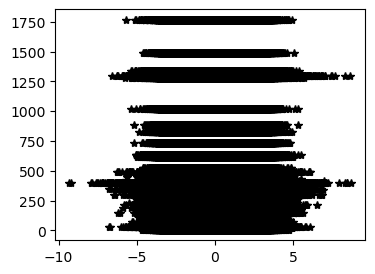

In [6]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = y_preds.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.cpu(), train_y.cpu(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.cpu(), y_preds.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.cpu(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])